This Notebook/demo uses spike interface, [here is how to install Spike Interface](https://spikeinterface.readthedocs.io/en/latest/installation.html)

In [1]:
import os
os.chdir(r"Q:/sachuriga/Sachuriga_Python/quattrocolo-nwb4fp/src")

import sys
from pathlib import Path

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import UnitMatchPy.extract_raw_data as erd
import numpy as np 
import probeinterface as pi
import spikeinterface.exporters as sex
from spikeinterface.preprocessing import (bandpass_filter,
                                           common_reference,
                                           whiten)
from spikeinterface.extractors.neoextractors.openephys import OpenEphysBinaryRecordingExtractor
import os
import glob

from nwb4fp.CR_CA1_paper.Unit_match.unit_match_files import load_filen ,run_unitmatch

C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the base path
ephys_path = r'S:/Sachuriga/Ephys_Recording/CR_CA1'

# Find all folders ending with "_phy_k_manual"
pattern = rf'{ephys_path}/*/*_phy_k_manual'
phy_folders = glob.glob(pattern)

valid_animals = ["65165", "65091", "63383", "63385", "65588", "66537", "66538", "66539", "66922", "65622"]
#valid_animals = ["66537", "66538", "66539", "66922", "65622"]
# Initialize set to track processed animal-day combinations
processed_days = set()

# Process each folder
results = {}
for folder in phy_folders:
    folder_name = os.path.basename(folder)
    parts = folder_name.split("_")
    
    if len(parts) >= 2:
        animal = parts[0]
        day = parts[1]
        
        # Pass processed_days to load_filen
        result = load_filen(animal, day, ephys_path, valid_animals, processed_days)
        if result:
            results[folder_name] = {
                'raw_path': result[0],
                'phy_folder': result[1]
            }

# Print results
paths = [[], []]
for folder_name, data in results.items():
    print(f"\nFolder: {folder_name}")
    print("Raw paths:")
    raw_path = []
    phy_folder = []
    
    for path_list in data['raw_path']:
        raw_path.append(path_list)
    print("Phy folders:")
    for folder_list in data['phy_folder']:
        phy_folder.append(folder_list)
    
    print(raw_path)
    print(phy_folder)
    paths[0].append(raw_path)
    paths[1].append(phy_folder)


Folder: 63383_2024-07-13_14-10-05_A_phy_k_manual
Raw paths:
Phy folders:
[['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-13_14-10-05_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-13_14-42-37_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-13_15-10-36_C']]
[['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-13_14-10-05_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-13_14-42-37_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-13_15-10-36_C_phy_k_4match']]

Folder: 63383_2024-07-15_14-51-19_A_phy_k_manual
Raw paths:
Phy folders:
[['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-15_14-51-19_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-15_15-18-02_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-15_15-44-58_C']]
[['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-15_14-51-19_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recor

processing the file: ([['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-13_14-10-05_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-13_14-42-37_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-13_15-10-36_C']], [['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-13_14-10-05_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-13_14-42-37_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-13_15-10-36_C_phy_k_4match']])
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#Acquisition_Board-100.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 102#OE_FPGA_Acquisition_Board-101.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#Acquisition_Board-100.Rhythm 

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.50it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 768/768 [00:57<00:00, 13.35it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.12it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 768/768 [00:59<00:00, 12.99it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.45it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 673/673 [00:50<00:00, 13.26it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 673/673 [00:52<00:00, 12.86it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 706/706 [01:00<00:00, 11.67it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\63383\63383_2024-07-13_UMInputData
Unit0
Unit1
Unit2
Unit4
Unit5
Unit7
Unit8
Unit9
Unit10
Unit12
Unit14
Unit16
Unit17
Unit18
Unit20
Saved 16 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit5
Unit6
Unit7
Unit9
Unit10
Unit11
Unit16
Unit18
Unit19
Unit20
Unit22
Saved 15 units to RawWaveforms directory, saving all units
Unit1
Unit2
Unit4
Unit6
Unit11
Unit12
Unit13
Unit14
Unit15
Unit17
Unit18
Unit19
Unit20
Saved 14 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:244: RuntimeWarning: invalid value encountered in divide
  mu = np.sum( np.tile(spatial_fp[:], (1,3)) * loc, axis = 0) / np.sum(spatial_fp[:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:335: RuntimeWarning: All-NaN slice encountered
  tmp_peak = np.nanmax(avg_waveform[:,i,cv])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:46: RuntimeWarning: Mean of empty slice
  diff = np.abs(x1 - x2) / np.nanmean(np.abs( np.stack((x1,x2), axis = -1)), axis = 2)
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:111: RuntimeWarning: All-NaN slice encountered
  projected_waveform_norm =  (projected_waveform_norm - np.nanmin(projected_waveform_norm,axis = 0)) / (np.nanmax(projected_waveform_norm, axis=0) - np.nanmin(projected_waveform_norm, axis 

This unit 17, CV 0 is very likely a bad unit!
This unit 17, CV 1 is very likely a bad unit!
unit17 is very likely bad, no good time points in average waveform
unit17 is very likely bad, no good time points in average waveform
Here is the paires[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True False]
 [False False False ... False False  True]]
Session pair 1/2 has [3 3 2] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [2 1 3] matches per shank, which is below threshold to do per shank drift correction
[0.66111234 0.46865911 0.49626705 0.5538339  0.56739736 0.48054717
 0.62851695 0.52222002 0.75203405 0.44708262 0.50112026 0.52200436
 0.62830476 0.74915792 0.74247377 0.67548803 0.75850158 0.76756777
 0.6149827  0.74239641 0.66445863 0.49680729 0.76627169 0.74465516
 0.69858609 

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.26it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 606/606 [00:32<00:00, 18.58it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  8.14it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 606/606 [00:31<00:00, 19.45it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.90it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 642/642 [00:12<00:00, 51.13it/s] 
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.17it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 642/642 [00:12<00:00, 51.74it/s] 
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 602/602 [00:05<00:00, 102.73it/s]
noise_level (no parallelization): 100%|████████

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\63383\63383_2024-07-15_UMInputData
Unit3
Unit13
Unit17
Saved 4 units to RawWaveforms directory, saving all units
Unit0
Unit4
Unit5
Saved 4 units to RawWaveforms directory, saving all units
Unit0
Unit1
Saved 3 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295, 0.305, 0.315,

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: divide by zero encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Here is the paires[[False False False False False False False False]
 [False  True False False False False False False]
 [False False  True  True False False  True False]
 [False False  True  True False False  True False]
 [False False False False  True False False False]
 [False False False False False  True False  True]
 [False False  True  True False False  True False]
 [False False False False False  True False  True]]
Error occurred for files: [['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-15_14-51-19_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-15_15-18-02_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-15_15-44-58_C']] and [['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-15_14-51-19_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-15_15-18-02_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-15_15-44-58_C_phy_k_4match']]. Error: too many indices for array: arra

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.43it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 603/603 [00:51<00:00, 11.80it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.15it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 603/603 [00:48<00:00, 12.47it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.86it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 616/616 [00:45<00:00, 13.43it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.91it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 616/616 [00:50<00:00, 12.17it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  8.30it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 619/619 [00:50<00:00, 12.34it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\63383\63383_2024-07-18_UMInputData
Unit0
Unit1
Unit2
Unit3
Unit4
Unit6
Unit7
Unit9
Unit10
Unit11
Unit12
Unit13
Saved 13 units to RawWaveforms directory, saving all units
Unit0
Unit4
Unit5
Unit6
Unit7
Unit9
Unit11
Unit12
Unit13
Unit14
Unit15
Unit16
Unit18
Unit19
Unit20
Saved 16 units to RawWaveforms directory, saving all units
Unit0
Unit2
Unit3
Unit4
Unit7
Unit9
Unit10
Unit11
Unit12
Unit13
Unit14
Unit15
Unit16
Saved 14 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.0

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Here is the paires[[ True False False ... False False False]
 [False  True False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True False]
 [False False False ... False False  True]]
Session pair 1/2 has [2 3 2 1] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [2 3 3 1] matches per shank, which is below threshold to do per shank drift correction
[0.8240732  0.39528736 0.39451861 0.28287176 0.85896122 0.30784854
 0.56427501 0.29226013 0.86874827 0.60452108 0.29125816 0.93743418
 0.38358006 0.69592464 0.35413931 0.45170623 0.68880625 0.68680462
 0.38269042 0.60699257 0.18088943 0.41914851 0.16248572 0.3656894
 0.19924509 0.15323724 0.32815276 0.41074352 0.26775669 0.61186829
 0.30233271 0.96111983 0.27850839 0.48222612 0.76622497 0.62287855
 0.31357527 0.63758163 0.58675307 0.29496841 0.43382449 0.44095121
 0.8024606  0.26751395 0.4294775  

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  8.31it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 624/624 [00:48<00:00, 12.86it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.74it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 624/624 [00:48<00:00, 12.85it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.91it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 637/637 [00:51<00:00, 12.26it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.75it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 637/637 [00:51<00:00, 12.37it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.40it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 861/861 [01:07<00:00, 12.66it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\63383\63383_2024-07-20_UMInputData
Unit0
Unit1
Unit3
Unit4
Unit8
Unit10
Unit13
Unit14
Unit15
Unit16
Unit17
Saved 12 units to RawWaveforms directory, saving all units
Unit1
Unit3
Unit4
Unit5
Unit8
Unit10
Unit11
Unit12
Unit14
Unit15
Saved 11 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit3
Unit6
Unit7
Unit8
Unit9
Unit10
Unit11
Unit14
Unit18
Saved 12 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 632/632 [00:46<00:00, 13.49it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.81it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 632/632 [00:50<00:00, 12.41it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.00it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 658/658 [00:52<00:00, 12.46it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.84it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 658/658 [00:55<00:00, 11.93it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.46it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 691/691 [00:59<00:00, 11.55it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\63383\63383_2024-07-22_UMInputData
Unit0
Unit1
Unit2
Unit3
Unit5
Unit7
Unit8
Unit9
Unit10
Unit14
Unit15
Unit16
Unit17
Unit18
Unit19
Unit20
Unit21
Saved 18 units to RawWaveforms directory, saving all units
Unit1
Unit2
Unit3
Unit5
Unit6
Unit9
Unit10
Unit13
Unit16
Unit17
Unit18
Unit19
Unit20
Unit22
Unit25
Saved 16 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit3
Unit4
Unit6
Unit7
Unit8
Unit11
Unit12
Unit13
Unit14
Unit15
Saved 14 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Here is the paires[[False False False ... False False False]
 [False  True False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False False False]
 [False False  True ... False False  True]]
Session pair 1/2 has [4 2 5] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [2 1 3] matches per shank, which is below threshold to do per shank drift correction
[0.64086546 0.1000427  0.18813596 0.39660658 0.08815883 0.24200002
 0.3969011  0.78555534 0.43817418 0.45445227 0.33478464 0.21425694
 0.31877186 0.36763313 0.45692693 0.31695047 0.25223302 0.39130729
 0.10055885 0.76257535 0.35026407 0.61395635 0.61240266 0.31048681
 0.35679319 0.48961832 0.43451622 0.9038242  0.6369716  0.49019621
 0.38258094 0.29201493 0.35294665 0.39977425 0.54333513 0.5061284
 0.45483934 0.33385531 0.8828293  0.29592932 0.84990124 0.50986952
 0.46777575 0.60839703 0.19532613 0.88

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.56it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 653/653 [00:45<00:00, 14.21it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  8.04it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 653/653 [00:50<00:00, 12.92it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.39it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 605/605 [00:45<00:00, 13.41it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.31it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 605/605 [00:44<00:00, 13.46it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.78it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 648/648 [00:49<00:00, 13.02it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\63383\63383_2024-07-25_UMInputData
Unit0
Unit1
Unit3
Unit4
Unit5
Unit6
Unit7
Unit8
Unit9
Unit11
Unit12
Unit13
Unit14
Unit15
Unit16
Unit18
Unit19
Unit20
Unit24
Unit25
Unit28
Unit29
Unit33
Saved 24 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit3
Unit4
Unit5
Unit6
Unit7
Unit8
Unit9
Unit14
Unit16
Unit17
Unit19
Unit21
Unit23
Unit24
Unit25
Unit26
Unit31
Unit32
Unit33
Unit34
Saved 23 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit5
Unit6
Unit7
Unit10
Unit11
Unit12
Unit13
Unit15
Unit17
Unit19
Unit21
Unit24
Unit27
Unit28
Unit29
Saved 19 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'mi

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: divide by zero encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Here is the paires[[ True  True False ... False False False]
 [False False False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True False]
 [False False False ... False False  True]]
Session pair 1/2 has [2 2 1 4 2] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [2 4 2] matches per shank, which is below threshold to do per shank drift correction
[0.73095178 0.77125206 0.62801547 ... 0.58057093 0.45268762 0.8771905 ]
whats here 0.8734419942473634
Calculating the probability distributions of the metric scores
Calculating the match probabilities
The percentage of units matched to themselves is: 79.36507936507937%
The percentage of false -ve's then is: 20.634920634920633% 

The rate of miss-match(es) per expected match 0.09523809523809523
The percentage of false +ve's is 0.7905138339920948% for session 1
The percentage of false +ve's is 0.216

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.04it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 642/642 [00:49<00:00, 13.10it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 642/642 [00:47<00:00, 13.57it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.91it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 607/607 [00:45<00:00, 13.49it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.15it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 607/607 [00:44<00:00, 13.62it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.84it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 608/608 [00:47<00:00, 12.91it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\63383\63383_2024-07-28_UMInputData
Unit0
Unit1
Unit3
Unit4
Unit5
Unit6
Unit8
Unit9
Unit13
Unit17
Unit18
Unit19
Unit20
Unit21
Unit23
Unit28
Unit30
Unit31
Unit33
Unit35
Unit36
Saved 22 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit4
Unit9
Unit10
Unit12
Unit19
Unit21
Unit22
Unit23
Unit24
Unit25
Unit26
Unit27
Unit34
Unit35
Unit36
Unit37
Unit38
Unit39
Unit40
Unit41
Saved 24 units to RawWaveforms directory, saving all units
Unit12
Unit22
Unit25
Unit26
Unit27
Unit31
Unit41
Unit42
Unit43
Unit47
Saved 11 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, '

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:244: RuntimeWarning: invalid value encountered in divide
  mu = np.sum( np.tile(spatial_fp[:], (1,3)) * loc, axis = 0) / np.sum(spatial_fp[:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:335: RuntimeWarning: All-NaN slice encountered
  tmp_peak = np.nanmax(avg_waveform[:,i,cv])


This unit 44, CV 1 is very likely a bad unit!
unit44 is very likely bad, no good time points in average waveform
Here is the paires[[ True False False ... False False False]
 [False False False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ... False  True False]
 [False False False ... False  True False]
 [False False False ... False False  True]]
Session pair 1/2 has [1 2 1 4 6] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [3 3] matches per shank, which is below threshold to do per shank drift correction
[0.85507858 0.3844693  0.42989485 0.75348783 0.36311242 0.66882544
 0.41448569 0.66659328 0.65868062 0.39282666 0.97333531 0.3425777
 0.79577488 0.51842498 0.38093939 0.34420834 0.4942438  0.6378502
 0.99340726 0.77171792 0.52500098 0.34235934 0.38040117 0.43833697
 0.43987596 0.50280802 0.91319194 0.81226405 0.37283579 0.66226775
 0.40485329 0.38719926 0.79514969 0.3648225  0.54538339 0.

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:111: RuntimeWarning: All-NaN slice encountered
  projected_waveform_norm =  (projected_waveform_norm - np.nanmin(projected_waveform_norm,axis = 0)) / (np.nanmax(projected_waveform_norm, axis=0) - np.nanmin(projected_waveform_norm, axis = 0))
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:115: RuntimeWarning: Mean of empty slice
  raw_wave_mse = np.nanmean( (x1 - x2)**2, axis = 0 ).squeeze()
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:147: RuntimeWarning: All-NaN slice encountered
  new_vals = np.nanmin(tmpdat, axis =1, keepdims=True) + np.nanmax(tmpdat, axis = 1, keepdims=True) - tmpdat
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:211: RuntimeWarning: All-NaN slice encountered
  centroid_dist = np.nanmin( euclid_dist[:,new

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\63383\63383_2024-07-28_unitmatchResults
processing the file: ([['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-30_12-33-52_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-30_13-03-12_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-30_13-33-47_C']], [['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-30_12-33-52_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-30_13-03-12_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-30_13-33-47_C_phy_k_4match']])
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#Acquisition_Board-100.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 102#OE_FPGA_Acquisition_Board-101.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 626/626 [00:51<00:00, 12.20it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.36it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 626/626 [00:50<00:00, 12.48it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.12it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 621/621 [00:50<00:00, 12.23it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.60it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 621/621 [00:51<00:00, 12.05it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 666/666 [00:55<00:00, 12.04it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\63383\63383_2024-07-30_UMInputData
Unit1
Unit2
Unit5
Unit6
Unit9
Unit13
Unit14
Unit15
Unit16
Unit17
Unit20
Unit21
Unit22
Unit23
Unit24
Unit26
Unit27
Unit28
Unit29
Unit30
Unit31
Saved 22 units to RawWaveforms directory, saving all units
Unit1
Unit2
Unit3
Unit5
Unit6
Unit7
Unit8
Unit10
Unit11
Unit12
Unit14
Unit15
Unit17
Unit18
Unit21
Unit22
Unit24
Unit25
Unit26
Unit28
Unit29
Unit31
Saved 23 units to RawWaveforms directory, saving all units
Unit0
Unit2
Unit3
Unit5
Unit6
Unit7
Unit8
Unit9
Unit10
Unit14
Unit15
Unit17
Unit18
Unit20
Unit21
Unit22
Unit26
Unit27
Unit28
Saved 20 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_a

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: divide by zero encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Here is the paires[[False False False ... False False False]
 [False  True False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False  True ... False False  True]]
Session pair 1/2 has [1 2 5] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [1 2 6] matches per shank, which is below threshold to do per shank drift correction
[0.71632588 0.43096311 0.19147684 ... 0.68286173 0.63782822 0.77957089]
whats here 0.891644908616188
Calculating the probability distributions of the metric scores
Calculating the match probabilities
The percentage of units matched to themselves is: 67.74193548387096%
The percentage of false -ve's then is: 32.25806451612904% 

The rate of miss-match(es) per expected match 0.25806451612903225
The percentage of false +ve's is 1.9047619047619049% for session 1
The percentage of false +ve's is 0.649350649

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.30it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 700/700 [00:56<00:00, 12.38it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.96it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 700/700 [00:58<00:00, 12.07it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.00it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 702/702 [00:59<00:00, 11.74it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.74it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 702/702 [01:03<00:00, 11.02it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.18it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 643/643 [00:54<00:00, 11.80it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\63385\63385_2024-07-13_UMInputData
Unit0
Unit1
Unit2
Unit3
Unit4
Unit5
Unit6
Unit7
Unit9
Unit13
Unit15
Unit17
Unit18
Unit19
Unit20
Unit21
Saved 17 units to RawWaveforms directory, saving all units
Unit0
Unit3
Unit4
Unit5
Unit7
Unit9
Unit11
Unit12
Unit13
Unit16
Unit17
Unit18
Unit21
Saved 14 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit3
Unit4
Unit5
Unit6
Unit7
Unit8
Unit9
Unit10
Unit11
Unit12
Unit13
Unit15
Saved 16 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Here is the paires[[ True False False ... False False False]
 [False  True  True ... False False False]
 [False False False ... False False False]
 ...
 [False False False ...  True  True False]
 [False False False ...  True  True False]
 [False False False ... False False  True]]
Session pair 1/2 has [2 2 2 1] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [4 2 1] matches per shank, which is below threshold to do per shank drift correction
[0.70405228 0.50967409 0.48962516 0.49213013 0.69139041 0.4972636
 0.46599607 0.49515753 0.54279467 0.77195332 0.50572125 0.45874495
 0.39240111 0.42699914 0.47072273 1.         0.69423726 0.48775872
 0.62861674 0.49122091 0.31958884 0.54323322 0.83553384 0.49654994
 0.62751268 0.87631555 0.40556149 0.58719121 0.55347387 0.63038016
 0.6319994  0.36143193 0.44736981 0.57104089 0.46810259 0.76187398
 0.68560087 0.55306955 0.69406819 0.58435783 0.64647734 0.49460845
 0.86101694 0.58707574 0.83416578 0.

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.60it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 609/609 [00:49<00:00, 12.25it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.65it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 609/609 [00:51<00:00, 11.80it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.21it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 608/608 [00:52<00:00, 11.63it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.92it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 608/608 [00:50<00:00, 11.92it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.94it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 603/603 [00:54<00:00, 11.15it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\63385\63385_2024-07-15_UMInputData
Unit0
Unit1
Unit3
Unit4
Unit5
Unit6
Unit7
Unit8
Unit13
Unit14
Unit15
Unit19
Saved 13 units to RawWaveforms directory, saving all units
Unit1
Unit2
Unit3
Unit4
Unit5
Unit8
Unit11
Unit14
Unit15
Unit16
Unit18
Unit19
Unit20
Unit21
Unit23
Saved 16 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit3
Unit6
Unit8
Unit13
Unit14
Unit15
Unit16
Unit17
Unit20
Saved 13 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.0

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: divide by zero encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Here is the paires[[ True False False ... False False False]
 [False  True False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ...  True False False]
 [ True False False ... False  True False]
 [False False False ... False False  True]]
Session pair 1/2 has [2 3 2] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [2 1 3 2] matches per shank, which is below threshold to do per shank drift correction
[0.78848528 0.44606362 0.57483389 0.6463463  0.48836207 0.86244786
 0.57763744 0.32417266 0.52548491 0.86854988 0.58363175 0.68150043
 0.73701679 0.32542373 0.70729327 0.35560544 0.76031345 0.34217067
 0.50276427 0.0608769  0.10475202 0.09652952 0.45050186 0.04364653
 0.80795171 0.08291994 0.90099799 0.65453124 0.11779895 0.24848243
 0.14430786 0.56454381 0.6265703  0.1536064  0.6432218  0.07508539
 0.63876981 0.53080568 0.69015201 0.94564445 0.25423096 0.33433835
 0.30418315 0.10002066 0.48999924 0

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.19it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 623/623 [00:52<00:00, 11.90it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.13it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 623/623 [00:51<00:00, 12.10it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.22it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 605/605 [00:46<00:00, 12.91it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.33it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 605/605 [00:43<00:00, 13.85it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.52it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 645/645 [00:48<00:00, 13.31it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\63385\63385_2024-07-18_UMInputData
Unit2
Unit4
Unit6
Unit8
Unit12
Unit13
Unit14
Unit18
Unit20
Saved 10 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit3
Unit5
Unit6
Unit8
Unit9
Unit10
Unit11
Unit13
Unit14
Unit15
Unit16
Unit17
Unit18
Unit19
Unit20
Unit21
Unit22
Unit23
Saved 22 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit4
Unit6
Unit8
Unit9
Unit10
Unit11
Unit12
Unit13
Unit14
Unit16
Unit18
Unit20
Unit21
Saved 16 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': a

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:244: RuntimeWarning: invalid value encountered in divide
  mu = np.sum( np.tile(spatial_fp[:], (1,3)) * loc, axis = 0) / np.sum(spatial_fp[:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:335: RuntimeWarning: All-NaN slice encountered
  tmp_peak = np.nanmax(avg_waveform[:,i,cv])


This unit 29, CV 1 is very likely a bad unit!
unit29 is very likely bad, no good time points in average waveform
Here is the paires[[ True False False ... False False False]
 [False  True False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True False]
 [False False False ... False False False]]
Session pair 1/2 has [3 3 2] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [3 4 2] matches per shank, which is below threshold to do per shank drift correction
[0.91752149 0.78495856 0.78502115 0.69180123 0.8554842  0.85407353
 0.71331977 0.85929886 0.89098373 0.75535447 0.81462428 0.75582309
 0.94091415 0.64832837 0.78074727 0.74118934 0.70633862 0.80631604
 0.73559141 0.7349445  0.91834993 0.70698862 0.76456528 0.72145776
 0.76260547 0.6383214  0.72628334 0.73863284 0.71197873 0.74011627
 0.74704886 0.67882603 0.84749395 0.69326916 0.48257869 0.

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:111: RuntimeWarning: All-NaN slice encountered
  projected_waveform_norm =  (projected_waveform_norm - np.nanmin(projected_waveform_norm,axis = 0)) / (np.nanmax(projected_waveform_norm, axis=0) - np.nanmin(projected_waveform_norm, axis = 0))
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:115: RuntimeWarning: Mean of empty slice
  raw_wave_mse = np.nanmean( (x1 - x2)**2, axis = 0 ).squeeze()
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:147: RuntimeWarning: All-NaN slice encountered
  new_vals = np.nanmin(tmpdat, axis =1, keepdims=True) + np.nanmax(tmpdat, axis = 1, keepdims=True) - tmpdat
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:211: RuntimeWarning: All-NaN slice encountered
  centroid_dist = np.nanmin( euclid_dist[:,new

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\63385\63385_2024-07-18_unitmatchResults
processing the file: ([['S:/Sachuriga/Ephys_Recording/CR_CA1\\63385\\63385_2024-07-20_16-14-52_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63385\\63385_2024-07-20_16-41-18_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63385\\63385_2024-07-20_17-08-19_C']], [['S:/Sachuriga/Ephys_Recording/CR_CA1\\63385\\63385_2024-07-20_16-14-52_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63385\\63385_2024-07-20_16-41-18_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63385\\63385_2024-07-20_17-08-19_C_phy_k_4match']])
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#Acquisition_Board-100.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 102#OE_FPGA_Acquisition_Board-101.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.16it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 618/618 [00:50<00:00, 12.12it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.35it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 618/618 [00:51<00:00, 11.99it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.90it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 635/635 [00:52<00:00, 12.14it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.81it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 635/635 [00:54<00:00, 11.75it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.70it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 675/675 [00:55<00:00, 12.20it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\63385\63385_2024-07-20_UMInputData
Unit2
Unit6
Unit7
Unit8
Unit12
Unit13
Unit15
Unit16
Unit17
Unit21
Unit22
Saved 12 units to RawWaveforms directory, saving all units
Unit3
Unit6
Unit7
Unit8
Unit9
Unit10
Unit11
Unit12
Unit14
Unit15
Unit16
Unit17
Unit18
Unit19
Unit20
Unit21
Unit22
Unit23
Unit24
Saved 20 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit3
Unit5
Unit7
Unit12
Unit15
Unit18
Unit19
Unit22
Saved 11 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.03

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:244: RuntimeWarning: invalid value encountered in divide
  mu = np.sum( np.tile(spatial_fp[:], (1,3)) * loc, axis = 0) / np.sum(spatial_fp[:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:335: RuntimeWarning: All-NaN slice encountered
  tmp_peak = np.nanmax(avg_waveform[:,i,cv])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:111: RuntimeWarning: All-NaN slice encountered
  projected_waveform_norm =  (projected_waveform_norm - np.nanmin(projected_waveform_norm,axis = 0)) / (np.nanmax(projected_waveform_norm, axis=0) - np.nanmin(projected_waveform_norm, axis = 0))
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:115: RuntimeWarning: Mean of empty slice
  raw_wave_mse = np.nanmean( (x1 - x2)**2, axis = 0 ).squeeze()
c:\Users\sachur\

This unit 34, CV 1 is very likely a bad unit!
unit34 is very likely bad, no good time points in average waveform
Here is the paires[[ True  True False ... False False False]
 [ True  True False ... False False False]
 [False False  True ...  True False False]
 ...
 [False False  True ...  True False False]
 [False False False ... False False False]
 [False False False ... False False  True]]
Session pair 1/2 has [2 4 4] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [3 2 1] matches per shank, which is below threshold to do per shank drift correction
[1.         0.71116542 0.87425167 0.69222204 0.76780955 0.66780107
 0.68657545 0.88341974 0.69907822 0.67721795 0.85905103 0.72059463
 0.74490972 0.78659034 0.81865626 0.77341707 0.69318121 0.78850115
 0.93198919 0.85092518 0.56564339 0.55940093 0.51220127 0.77170304
 0.47232169 0.51716833 0.59683835 0.87249004 0.50105263 0.45002695
 0.7058228  0.87381662 0.51767739 0.75062624 0.88805437 0.

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.59it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 634/634 [00:50<00:00, 12.55it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.72it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 634/634 [00:54<00:00, 11.63it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.13it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 744/744 [00:58<00:00, 12.73it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.43it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 744/744 [00:57<00:00, 13.04it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.90it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 610/610 [00:48<00:00, 12.65it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\63385\63385_2024-07-22_UMInputData
Unit0
Unit1
Unit2
Unit6
Unit7
Unit8
Unit12
Unit13
Unit15
Unit16
Unit17
Unit18
Unit19
Unit20
Unit22
Unit24
Unit25
Unit26
Saved 19 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit4
Unit5
Unit11
Unit12
Unit14
Unit15
Unit16
Unit17
Unit20
Unit23
Unit24
Unit26
Unit27
Unit30
Saved 18 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit3
Unit5
Unit6
Unit7
Unit8
Unit9
Unit11
Unit12
Unit13
Unit15
Unit16
Unit18
Unit22
Unit24
Unit27
Unit28
Saved 20 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_p

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:244: RuntimeWarning: invalid value encountered in divide
  mu = np.sum( np.tile(spatial_fp[:], (1,3)) * loc, axis = 0) / np.sum(spatial_fp[:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:335: RuntimeWarning: All-NaN slice encountered
  tmp_peak = np.nanmax(avg_waveform[:,i,cv])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:111: RuntimeWarning: All-NaN slice encountered
  projected_waveform_norm =  (projected_waveform_norm - np.nanmin(projected_waveform_norm,axis = 0)) / (np.nanmax(projected_waveform_norm, axis=0) - np.nanmin(projected_waveform_norm, axis = 0))
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:115: RuntimeWarning: Mean of empty slice
  raw_wave_mse = np.nanmean( (x1 - x2)**2, axis = 0 ).squeeze()
c:\Users\sachur\

This unit 53, CV 1 is very likely a bad unit!
unit53 is very likely bad, no good time points in average waveform
Here is the paires[[ True False False ... False False False]
 [False  True False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True False]
 [False False False ... False False False]]
Session pair 1/2 has [2 3 2 4] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [3 3 2 2] matches per shank, which is below threshold to do per shank drift correction
[0.8281902  0.58177193 0.53320781 0.66784686 0.89435884 0.66812142
 0.64952212 0.68034841 0.69263443 0.75527767 0.72930899 0.65194826
 0.68257997 0.90584974 0.68799131 0.44256405 0.91103189 0.66854674
 0.26937253 0.44919196 0.25600295 0.84527652 0.68972296 0.44511382
 0.31573207 0.46701513 0.69182974 0.75909039 0.58802867 0.59318623
 0.64357503 0.68384323 0.70481416 0.58723864 0.5691456

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.88it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 632/632 [01:01<00:00, 10.32it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 632/632 [00:56<00:00, 11.13it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.66it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 620/620 [01:00<00:00, 10.23it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.00it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 620/620 [01:05<00:00,  9.48it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.96it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 615/615 [01:11<00:00,  8.61it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\63385\63385_2024-07-25_UMInputData
Unit0
Unit1
Unit2
Unit3
Unit5
Unit6
Unit8
Unit13
Unit14
Unit15
Unit16
Unit19
Unit20
Saved 14 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit3
Unit4
Unit6
Unit8
Unit9
Unit10
Unit11
Unit14
Unit19
Unit20
Unit21
Unit23
Unit26
Unit27
Unit28
Unit29
Unit30
Saved 21 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit3
Unit4
Unit5
Unit6
Unit11
Unit12
Unit15
Unit16
Unit18
Unit19
Saved 14 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector'

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:244: RuntimeWarning: invalid value encountered in divide
  mu = np.sum( np.tile(spatial_fp[:], (1,3)) * loc, axis = 0) / np.sum(spatial_fp[:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:335: RuntimeWarning: All-NaN slice encountered
  tmp_peak = np.nanmax(avg_waveform[:,i,cv])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:111: RuntimeWarning: All-NaN slice encountered
  projected_waveform_norm =  (projected_waveform_norm - np.nanmin(projected_waveform_norm,axis = 0)) / (np.nanmax(projected_waveform_norm, axis=0) - np.nanmin(projected_waveform_norm, axis = 0))
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:115: RuntimeWarning: Mean of empty slice
  raw_wave_mse = np.nanmean( (x1 - x2)**2, axis = 0 ).squeeze()
c:\Users\sachur\

This unit 0, CV 1 is very likely a bad unit!
unit0 is very likely bad, no good time points in average waveform
Here is the paires[[False False False ... False False False]
 [False  True False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Session pair 1/2 has [1 2 5] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [1 2 4 1] matches per shank, which is below threshold to do per shank drift correction
[0.21582366 0.18898357 0.22440933 0.21072225 0.39594346 0.23385
 0.18367592 0.79831026 0.44066916 0.6433021  0.63911759 0.66246116
 0.52600234 0.84357317 0.70027658 0.77527698 0.74175369 0.43835351
 0.33632351 0.58867168 0.63501747 0.6115353  0.68192218 0.80763131
 0.50012529 0.64139006 0.79933381 0.64337644 0.68552365 0.55098641
 0.70443288 0.79045741 0.57777022 0.65480491 0.72778154 0.474

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.17it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 663/663 [00:57<00:00, 11.50it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.03it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 663/663 [01:01<00:00, 10.83it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.92it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 616/616 [00:50<00:00, 12.18it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.39it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 616/616 [00:52<00:00, 11.77it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.43it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 611/611 [00:47<00:00, 12.81it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\63385\63385_2024-07-28_UMInputData
Unit1
Unit2
Unit3
Unit5
Unit6
Unit7
Unit8
Unit11
Unit16
Saved 10 units to RawWaveforms directory, saving all units
Unit3
Unit4
Unit6
Unit7
Unit9
Unit10
Unit11
Unit12
Unit14
Unit17
Unit19
Saved 12 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit4
Unit7
Unit9
Unit11
Unit14
Unit16
Unit17
Unit18
Saved 11 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.11it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 632/632 [00:48<00:00, 12.98it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.26it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 632/632 [00:51<00:00, 12.31it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 628/628 [00:52<00:00, 11.87it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.20it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 628/628 [00:53<00:00, 11.82it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.41it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 643/643 [00:49<00:00, 12.93it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\63385\63385_2024-07-30_UMInputData
Unit0
Unit2
Unit3
Unit4
Unit7
Unit11
Unit12
Unit13
Unit16
Saved 10 units to RawWaveforms directory, saving all units
Unit1
Unit2
Unit3
Unit4
Unit6
Unit8
Unit10
Unit11
Saved 9 units to RawWaveforms directory, saving all units
Unit0
Unit2
Unit4
Unit5
Unit12
Unit13
Saved 7 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Here is the paires[[ True False False False False False False False False False False False
  False False False False False False False False False False False]
 [False  True False False  True False False False False False False False
  False False False False False False False False False False False]
 [False False False False False False False  True False False False  True
  False False False False False False False False False False False]
 [False False False  True False False False  True False  True False False
  False False False False False  True False False False False False]
 [False False False False  True False False False False False False False
  False False False False False False False False False False False]
 [False False False False False  True False False False False False False
  False  True False False False False False False False False  True]
 [False False False False False False False False False False False False
  False False False False False False False False 

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 717/717 [00:57<00:00, 12.40it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.21it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 717/717 [01:01<00:00, 11.63it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 609/609 [00:51<00:00, 11.72it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 609/609 [00:51<00:00, 11.85it/s]


Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\65091\65091_2023-08-01_UMInputData
Unit0
Unit1
Unit2
Unit3
Unit4
Unit5
Unit6
Unit7
Unit8
Unit9
Unit11
Unit15
Unit17
Saved 14 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit3
Unit4
Unit5
Unit6
Unit7
Unit10
Unit11
Unit12
Unit13
Unit19
Unit21
Saved 15 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,


c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:121: RuntimeWarning: overflow encountered in exp
  return p_1 * np.exp(-p_2 * d)
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:244: RuntimeWarning: invalid value encountered in divide
  mu = np.sum( np.tile(spatial_fp[:], (1,3)) * loc, axis = 0) / np.sum(spatial_fp[:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:335: RuntimeWarning: All-NaN slice encountered
  tmp_peak = np.nanmax(avg_waveform[:,i,cv])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:111: RuntimeWarning: All-NaN slice encountered
  projected_waveform_norm =  (projected_waveform_norm - np.nanmin(projected_waveform_norm,axis = 0)) / (np.nanmax(projected_waveform_norm, axis=0) - np.nanmin(projected_waveform_norm, axis = 0))
c:\Users\sachur\AppData\Local\anaconda3\e

This unit 16, CV 1 is very likely a bad unit!
This unit 18, CV 1 is very likely a bad unit!
unit18 is very likely bad, no good time points in average waveform
Here is the paires[[ True False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False]
 [False  True False False False False False False False False False False
  False  True False  True False False False False False False False False
  False False False]
 [False False  True False False False False False False False False False
  False False False False False False False False False False False False
  False False False]
 [False False False  True False False False False False False False False
  False False False False False False False False False False False False
   True False False]
 [False False False False  True False False False False False False False
  False False False False False False False False False False False False

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.18it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 503/503 [00:40<00:00, 12.52it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.80it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 503/503 [00:41<00:00, 12.15it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 485/485 [00:45<00:00, 10.60it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.93it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 485/485 [00:44<00:00, 10.99it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.26it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 498/498 [00:42<00:00, 11.59it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\65091\65091_2023-08-08_UMInputData
Unit1
Unit2
Unit3
Unit6
Unit10
Unit12
Unit15
Unit16
Unit18
Unit22
Saved 11 units to RawWaveforms directory, saving all units
Unit1
Unit2
Unit3
Unit4
Unit11
Unit17
Unit18
Unit21
Unit22
Saved 10 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit3
Unit8
Unit9
Unit10
Unit12
Unit13
Unit14
Unit19
Unit20
Unit21
Unit22
Saved 15 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.09

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: divide by zero encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Here is the paires[[ True False False ... False False False]
 [False  True False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False  True False]
 [False False False ... False False  True]]
Session pair 1/2 has [1] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [1 4] matches per shank, which is below threshold to do per shank drift correction
[0.7797324  0.3994827  0.8558093  0.4724708  0.8069858  0.5019839
 0.48401587 0.9183082  0.7453024  0.16082488 0.60368229 0.75450371
 0.63063206 0.55348491 0.71772703 0.69219327 0.2132998  0.48465947
 0.89984121 0.56296542 0.77225877 0.14857965 0.59817176 0.76415471
 0.82634138 0.72543818 0.42396947 0.61217742 0.2675854  0.72857543
 0.94343696 0.18577476 0.59006236 0.67232778 0.67898809 0.65660337
 0.77445414 0.68826798 0.21144265 0.46055423 0.73729222 0.62022439
 0.73537485 0.15453726 0.6119143  0.70437025

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 614/614 [01:06<00:00,  9.29it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 614/614 [01:05<00:00,  9.39it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.74it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 616/616 [01:07<00:00,  9.18it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.29it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 616/616 [00:59<00:00, 10.39it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.47it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 607/607 [00:52<00:00, 11.62it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\65165\65165_2023-07-10_UMInputData
Unit1
Unit2
Unit5
Unit7
Unit8
Unit9
Unit11
Unit12
Unit14
Unit16
Unit17
Unit20
Unit22
Unit23
Saved 15 units to RawWaveforms directory, saving all units
Unit1
Unit4
Unit9
Unit10
Unit16
Unit17
Unit19
Unit26
Unit27
Unit28
Unit31
Unit32
Unit33
Unit35
Unit43
Saved 16 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit3
Unit4
Unit9
Unit10
Unit15
Unit16
Unit19
Unit21
Unit26
Unit27
Saved 14 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Here is the paires[[ True False False ... False False False]
 [False False False ... False False False]
 [False False  True ...  True False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True  True]
 [False False False ... False  True  True]]
Session pair 1/2 has [2 2] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [3] matches per shank, which is below threshold to do per shank drift correction
[0.78979202 0.34944874 0.36304013 0.73837762 0.5694416  0.40387391
 0.56963143 0.61741979 0.71448174 0.36638205 0.54995464 0.6618772
 0.35830914 0.53961443 0.49347081 0.56181484 0.58888914 0.63619478
 0.33354136 0.7209324  0.66132225 0.48069539 0.55412636 0.45851648
 0.29876275 0.68925509 0.40018688 0.53233897 0.07563973 0.
 0.29071196 0.66307468 0.379107   0.09477288 0.37176321 0.4788974
 0.39439657 0.39158997 0.94159954 0.61183438 0.41128814 0.3823908
 0.72782453 0.37119331 0.41147275 0.38556144 0.6422452

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.79it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 643/643 [00:53<00:00, 11.98it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.84it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 643/643 [00:55<00:00, 11.50it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 738/738 [00:57<00:00, 12.91it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.30it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 738/738 [01:00<00:00, 12.17it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.72it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 609/609 [00:41<00:00, 14.60it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\65588\65588_2024-03-04_UMInputData
Unit0
Unit1
Unit2
Unit3
Unit4
Unit5
Unit7
Unit8
Unit9
Unit10
Unit12
Unit13
Unit14
Unit15
Unit16
Unit19
Unit20
Unit24
Unit25
Unit26
Unit28
Unit31
Unit38
Unit45
Saved 25 units to RawWaveforms directory, saving all units
Unit1
Unit2
Unit7
Unit8
Unit9
Unit10
Unit11
Unit12
Unit14
Unit15
Unit18
Unit21
Unit22
Unit25
Unit26
Unit29
Unit34
Unit35
Unit36
Unit43
Unit44
Unit48
Saved 23 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit4
Unit8
Unit10
Unit12
Unit13
Unit14
Unit15
Unit16
Unit17
Unit18
Unit19
Unit20
Unit21
Unit22
Unit23
Unit26
Unit27
Unit28
Unit29
Unit30
Unit33
Unit36
Unit38
Unit39
Unit40
Unit45
Unit47
Unit48
Unit49
Saved 33 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'chan

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: divide by zero encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Here is the paires[[ True False False ... False False False]
 [False False False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ...  True  True False]
 [False False False ... False False  True]]
Session pair 1/2 has [2 3 3 2 3] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [2 5 3 3 3] matches per shank, which is below threshold to do per shank drift correction
[1.         0.23922687 0.2234446  ... 0.51361482 0.35021146 0.93171541]
whats here 0.8852005532503457
Calculating the probability distributions of the metric scores
Calculating the match probabilities
The percentage of units matched to themselves is: 73.07692307692307%
The percentage of false -ve's then is: 26.923076923076934% 

The rate of miss-match(es) per expected match 0.07692307692307693
The percentage of false +ve's is 0.0% for session 1
The percentage of false +ve's is 0.21645021645021

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.04it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 709/709 [00:53<00:00, 13.14it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.39it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 709/709 [00:55<00:00, 12.78it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.17it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 706/706 [00:54<00:00, 12.84it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.88it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 706/706 [00:53<00:00, 13.08it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.98it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 620/620 [00:52<00:00, 11.92it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\65588\65588_2024-03-06_UMInputData
Unit2
Unit3
Unit4
Unit5
Unit6
Unit7
Unit12
Unit13
Unit14
Unit16
Unit17
Unit19
Unit20
Unit22
Unit23
Unit25
Unit26
Unit29
Unit30
Unit32
Unit34
Unit35
Unit37
Unit42
Unit44
Unit45
Saved 27 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit3
Unit4
Unit5
Unit7
Unit8
Unit9
Unit10
Unit11
Unit12
Unit13
Unit14
Unit16
Unit17
Unit18
Unit19
Unit20
Unit21
Unit22
Unit25
Unit26
Unit28
Unit29
Unit30
Unit37
Unit38
Unit39
Saved 29 units to RawWaveforms directory, saving all units
Unit0
Unit2
Unit3
Unit4
Unit5
Unit7
Unit8
Unit9
Unit10
Unit12
Unit14
Unit15
Unit17
Unit18
Unit19
Unit22
Unit23
Unit24
Unit25
Unit28
Unit30
Unit35
Unit36
Unit38
Unit40
Unit42
Saved 27 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: divide by zero encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Here is the paires[[ True False False ... False False False]
 [False False False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True  True]
 [False False False ...  True  True  True]]
Session pair 1/2 has [2 3 1] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [2 3 1 4 3] matches per shank, which is below threshold to do per shank drift correction
[0.7787926  0.70003481 0.58955006 ... 0.78677179 0.80693854 0.85838748]
whats here 0.9023224043715847
Calculating the probability distributions of the metric scores
Calculating the match probabilities
The percentage of units matched to themselves is: 60.0%
The percentage of false -ve's then is: 40.0% 

The rate of miss-match(es) per expected match 0.0875
The percentage of false +ve's is 0.15384615384615385% for session 1
The percentage of false +ve's is 0.26455026455026454% for session 2
The perce

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.85it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 745/745 [01:11<00:00, 10.47it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:04<00:00,  4.78it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 745/745 [01:08<00:00, 10.83it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.62it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 607/607 [00:54<00:00, 11.13it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.57it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 607/607 [00:55<00:00, 10.86it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.73it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 645/645 [00:56<00:00, 11.50it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\65588\65588_2024-03-08_UMInputData
Unit0
Unit1
Unit3
Unit4
Unit5
Unit9
Unit10
Unit11
Unit13
Unit14
Unit15
Unit16
Unit18
Unit21
Unit23
Unit24
Unit26
Unit29
Unit31
Unit32
Unit33
Saved 22 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit4
Unit5
Unit6
Unit7
Unit9
Unit13
Unit14
Unit15
Unit16
Unit18
Unit22
Unit23
Unit26
Unit28
Unit31
Saved 18 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit5
Unit9
Unit10
Unit11
Unit15
Unit17
Unit20
Unit21
Unit22
Unit23
Unit24
Unit25
Unit26
Unit27
Unit31
Unit32
Saved 20 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_d

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:121: RuntimeWarning: overflow encountered in exp
  return p_1 * np.exp(-p_2 * d)
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:121: RuntimeWarning: overflow encountered in multiply
  return p_1 * np.exp(-p_2 * d)
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: divide by zero encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Here is the paires[[ True False False ... False False False]
 [False False False ...  True False False]
 [False False  True ... False False  True]
 ...
 [False  True False ...  True False False]
 [False False False ... False  True False]
 [False False  True ... False False  True]]
Session pair 1/2 has [2 3] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [3 4 1] matches per shank, which is below threshold to do per shank drift correction
[0.83202073 0.50622942 0.32665105 0.68373312 0.54967034 0.44121794
 0.14491296 0.3377023  0.66432564 0.6100258  0.21976904 0.22417232
 0.46854585 0.37589846 0.63920189 0.60090084 0.27946298 0.27327958
 0.55949151 0.61440774 0.569051   0.64127197 0.30934996 0.55075322
 0.47477077 0.50037921 0.19113999 0.36613228 0.71006874 0.52405314
 0.29728583 0.24589645 0.63889839 0.45622163 0.56723527 0.50397545
 0.36792165 0.3080759  0.66975274 0.76147022 0.764552   0.65022376
 0.64227725 0.73435697 0.7181221  0.559

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.35it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 673/673 [00:55<00:00, 12.12it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.07it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 673/673 [00:59<00:00, 11.34it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.94it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 689/689 [01:00<00:00, 11.36it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.62it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 689/689 [00:53<00:00, 12.91it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.06it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 652/652 [00:53<00:00, 12.12it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\65588\65588_2024-03-10_UMInputData
Unit0
Unit1
Unit3
Unit5
Unit12
Unit13
Unit14
Unit24
Unit26
Unit28
Saved 11 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit8
Unit10
Unit12
Unit14
Unit15
Unit16
Unit20
Unit23
Unit34
Saved 13 units to RawWaveforms directory, saving all units
Unit1
Unit4
Unit5
Unit6
Unit9
Unit10
Unit11
Unit12
Unit13
Unit14
Unit15
Unit17
Unit21
Unit24
Unit27
Unit28
Saved 17 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.0

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: divide by zero encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Here is the paires[[ True False False ... False False False]
 [False  True False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True  True]
 [False False False ... False  True  True]]
Session pair 1/2 has [2 2] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [3 1 3] matches per shank, which is below threshold to do per shank drift correction
[0.79696536 0.5777152  0.44475959 0.49054829 0.50815668 0.36230914
 0.65521101 0.65806969 0.45012397 0.83884198 0.63704673 0.50770678
 0.91787428 0.4312546  0.41222441 0.65178944 0.19933739 0.43399892
 0.47190609 0.54120084 0.5958003  0.45092603 0.80801561 0.39517608
 0.59462396 0.30281153 0.29931195 0.61239615 0.39716688 0.64158672
 0.68572088 0.53587392 0.35237032 0.49393953 0.49360551 0.57241518
 0.55366722 0.46588327 0.94612361 0.51478438 0.51122287 0.27488933
 0.63091235 0.72168756 0.50149805 0.485

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 653/653 [01:01<00:00, 10.66it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.10it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 653/653 [01:01<00:00, 10.58it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.78it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 622/622 [00:49<00:00, 12.47it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 622/622 [00:48<00:00, 12.91it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.88it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 628/628 [00:56<00:00, 11.10it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\65588\65588_2024-03-12_UMInputData
Unit5
Unit12
Unit14
Unit15
Unit18
Unit23
Unit24
Unit25
Unit26
Unit28
Unit32
Saved 12 units to RawWaveforms directory, saving all units
Unit0
Unit5
Unit7
Unit8
Unit9
Unit10
Unit13
Unit17
Unit18
Unit21
Unit22
Unit25
Saved 13 units to RawWaveforms directory, saving all units
Unit0
Unit3
Unit5
Unit6
Unit8
Unit12
Unit13
Unit16
Unit17
Unit18
Unit25
Unit26
Unit28
Saved 14 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: divide by zero encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Here is the paires[[ True False False ... False False False]
 [False  True False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True False]
 [False False False ... False False False]]
Session pair 1/2 has [1 4 1] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [1 4] matches per shank, which is below threshold to do per shank drift correction
[0.80964368 0.52250237 0.85600659 0.85880614 0.5107436  0.47312609
 0.38062671 0.84137222 0.50997152 0.37194663 0.51345362 0.41040067
 0.43447462 0.82209308 0.51972351 0.49565519 0.37313707 0.56666789
 0.39152904 0.31243659 0.32613516 0.44703623 0.44124943 0.62749339
 0.37426157 0.37358016 0.26288344 0.24373645 0.3699646  0.47605409
 1.         0.68909504 0.59967563 0.4745933  0.9461053  0.57963101
 0.61910328 0.54209168 0.65673884 0.48539053 0.74562238 0.59078541
 0.58454775 0.67088393 0.42354285 0.374

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.51it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 782/782 [01:14<00:00, 10.49it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.10it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 782/782 [01:08<00:00, 11.46it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  8.04it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 609/609 [00:46<00:00, 13.06it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.00it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 609/609 [00:44<00:00, 13.60it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  8.09it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 668/668 [00:49<00:00, 13.49it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\65588\65588_2024-03-14_UMInputData
Unit4
Unit6
Unit10
Unit11
Unit13
Unit21
Unit22
Unit25
Unit33
Saved 10 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit3
Unit7
Unit8
Unit12
Unit13
Unit14
Unit18
Unit23
Unit24
Unit25
Unit26
Unit27
Unit28
Unit30
Unit31
Unit33
Unit34
Unit37
Unit39
Unit40
Unit43
Unit45
Saved 26 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit7
Unit8
Unit14
Unit15
Unit19
Unit20
Unit21
Unit22
Unit23
Unit24
Unit29
Unit31
Unit36
Unit38
Unit41
Unit44
Saved 19 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_sha

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: divide by zero encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Here is the paires[[ True False False ... False False False]
 [False  True False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False  True False]
 [False False False ... False False  True]]
Session pair 1/2 has [1 3 2] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [1 4 3 2] matches per shank, which is below threshold to do per shank drift correction
[0.79512467 0.26432601 0.56645638 0.2158138  0.32638058 0.37907801
 0.9008456  0.68193158 0.64294872 0.58235266 0.57102571 0.65811703
 0.59893623 0.3079509  0.57643038 0.69268237 0.62082394 0.5786383
 0.18736816 0.44533683 0.55582504 0.87163304 0.63811571 0.61601594
 0.60633255 0.73448736 0.56521252 0.2602231  0.87935617 0.4725332
 0.52256193 0.80745014 0.49310351 0.39576902 0.34715202 0.47293792
 0.32393213 0.36163544 0.80133128 0.48282076 0.30291091 0.5790968
 0.72730997 0.51986952 0.73076117 0.41

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.07it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 662/662 [00:22<00:00, 29.94it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.10it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 662/662 [00:21<00:00, 30.61it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.81it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 685/685 [00:01<00:00, 393.82it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.87it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 685/685 [00:08<00:00, 79.42it/s] 
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.69it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 633/633 [00:06<00:00, 95.04it/s] 
noise_level (no parallelization): 100%|████████

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66537\66537_2024-11-22_UMInputData
Unit0
Unit1
Saved 3 units to RawWaveforms directory, saving all units
Unit1
Saved 2 units to RawWaveforms directory, saving all units
Unit5
Unit8
Saved 3 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295, 0.305, 0.315, 0.325, 0.335, 0.345

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:244: RuntimeWarning: invalid value encountered in divide
  mu = np.sum( np.tile(spatial_fp[:], (1,3)) * loc, axis = 0) / np.sum(spatial_fp[:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:335: RuntimeWarning: All-NaN slice encountered
  tmp_peak = np.nanmax(avg_waveform[:,i,cv])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:111: RuntimeWarning: All-NaN slice encountered
  projected_waveform_norm =  (projected_waveform_norm - np.nanmin(projected_waveform_norm,axis = 0)) / (np.nanmax(projected_waveform_norm, axis=0) - np.nanmin(projected_waveform_norm, axis = 0))
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:115: RuntimeWarning: Mean of empty slice
  raw_wave_mse = np.nanmean( (x1 - x2)**2, axis = 0 ).squeeze()
c:\Users\sachur\

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66537\66537_2024-11-22_unitmatchResults
processing the file: ([['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-11-26_12-58-02_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-11-26_13-23-16_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-11-26_13-47-20_C']], [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-11-26_12-58-02_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-11-26_13-23-16_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-11-26_13-47-20_C_phy_k_4match']])
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#OE_FPGA_Acquisition_Board-117.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 102#OE_FPGA_Acquisition_Board-101.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannua

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.91it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 630/630 [00:38<00:00, 16.24it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.87it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 630/630 [00:39<00:00, 15.86it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.25it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 628/628 [01:00<00:00, 10.34it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.57it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 628/628 [00:55<00:00, 11.23it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.12it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 687/687 [00:43<00:00, 15.84it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66537\66537_2024-11-26_UMInputData
Unit6
Unit7
Unit8
Saved 4 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit3
Unit4
Unit5
Saved 7 units to RawWaveforms directory, saving all units
Unit1
Unit2
Unit3
Saved 4 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.33it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 631/631 [00:52<00:00, 12.00it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.04it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 631/631 [00:56<00:00, 11.26it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.05it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 636/636 [00:29<00:00, 21.71it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.74it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 636/636 [00:31<00:00, 20.38it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.10it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 659/659 [00:43<00:00, 15.00it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66537\66537_2024-11-29_UMInputData
Unit0
Unit1
Unit2
Unit3
Unit4
Unit5
Unit6
Unit7
Saved 9 units to RawWaveforms directory, saving all units
Unit8
Saved 2 units to RawWaveforms directory, saving all units
Unit10
Unit11
Saved 3 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.94it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 627/627 [00:02<00:00, 229.27it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.29it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 627/627 [00:05<00:00, 106.97it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.95it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 636/636 [00:05<00:00, 121.66it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.46it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 636/636 [00:03<00:00, 173.45it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.27it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 658/658 [00:03<00:00, 187.94it/s]
noise_level (no parallelization): 100%|██████

Error occurred for files: [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-02_11-51-18_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-02_12-18-56_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-02_12-44-40_C']] and [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-02_11-51-18_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-02_12-18-56_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-02_12-44-40_C_phy_k_4match']]. Error: estimate_templates() need non empty sorting
str(e)
processing the file: ([['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-04_14-35-16_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-04_15-00-57_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-04_15-27-58_C']], [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-04_14-35-16_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-04

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.80it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 634/634 [00:43<00:00, 14.68it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  8.02it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 634/634 [00:46<00:00, 13.58it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.87it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 664/664 [00:52<00:00, 12.64it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.36it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 664/664 [00:53<00:00, 12.34it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.40it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 716/716 [00:50<00:00, 14.21it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66537\66537_2024-12-04_UMInputData
Unit0
Unit4
Unit5
Unit7
Saved 5 units to RawWaveforms directory, saving all units
Unit5
Unit6
Unit9
Unit13
Unit15
Saved 6 units to RawWaveforms directory, saving all units
Unit9
Unit10
Unit11
Unit12
Unit16
Saved 6 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
 

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:121: RuntimeWarning: overflow encountered in exp
  return p_1 * np.exp(-p_2 * d)
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:244: RuntimeWarning: invalid value encountered in divide
  mu = np.sum( np.tile(spatial_fp[:], (1,3)) * loc, axis = 0) / np.sum(spatial_fp[:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:335: RuntimeWarning: All-NaN slice encountered
  tmp_peak = np.nanmax(avg_waveform[:,i,cv])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:111: RuntimeWarning: All-NaN slice encountered
  projected_waveform_norm =  (projected_waveform_norm - np.nanmin(projected_waveform_norm,axis = 0)) / (np.nanmax(projected_waveform_norm, axis=0) - np.nanmin(projected_waveform_norm, axis = 0))
c:\Users\sachur\AppData\Local\anaconda3\e

This unit 12, CV 1 is very likely a bad unit!
unit12 is very likely bad, no good time points in average waveform
Here is the paires[[ True False False False False False False  True False  True  True False
  False False]
 [False  True False False False False False False False False False False
  False False]
 [False False  True  True False False False False False False False False
  False False]
 [False False  True  True  True False False False False False False False
  False False]
 [False False False  True  True False False False False False False False
  False False]
 [False False False False False  True False False False False False False
  False False]
 [False False False False False False  True False False False False False
  False False]
 [ True  True False False False False False  True False  True  True False
  False False]
 [False False False False False False False False  True False False  True
  False False]
 [ True  True False False False False  True  True False  True  True 

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.10it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 659/659 [00:39<00:00, 16.58it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.74it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 659/659 [00:36<00:00, 17.81it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.88it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 639/639 [00:38<00:00, 16.73it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.51it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 639/639 [00:44<00:00, 14.24it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.53it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 610/610 [00:46<00:00, 13.12it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66537\66537_2024-12-06_UMInputData
Unit10
Unit12
Unit14
Saved 4 units to RawWaveforms directory, saving all units
Unit8
Unit18
Saved 3 units to RawWaveforms directory, saving all units
Unit5
Unit7
Unit9
Unit13
Saved 5 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295, 0.30

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:147: RuntimeWarning: All-NaN slice encountered
  new_vals = np.nanmin(tmpdat, axis =1, keepdims=True) + np.nanmax(tmpdat, axis = 1, keepdims=True) - tmpdat
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:211: RuntimeWarning: All-NaN slice encountered
  centroid_dist = np.nanmin( euclid_dist[:,new_peak_loc - waveidx ==0,:,:].squeeze(), axis =1 ).squeeze()
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:220: RuntimeWarning: Degrees of freedom <= 0 for slice.
  centroid_var = np.nanmin( np.nanvar(euclid_dist, axis = 1, ddof = 1 ).squeeze(), axis =1 ).squeeze()
c:\Users\sachur\AppData\Local\anaco

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66537\66537_2024-12-06_unitmatchResults
processing the file: ([['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-08_15-50-09_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-08_16-13-58_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-08_16-38-13_C']], [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-08_15-50-09_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-08_16-13-58_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-08_16-38-13_C_phy_k_4match']])
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#OE_FPGA_Acquisition_Board-117.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 102#OE_FPGA_Acquisition_Board-101.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannua

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.44it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 608/608 [00:05<00:00, 108.98it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.26it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 608/608 [00:04<00:00, 142.62it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.65it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 640/640 [00:39<00:00, 16.07it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.87it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 640/640 [00:35<00:00, 17.85it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.74it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 628/628 [00:05<00:00, 105.94it/s]
noise_level (no parallelization): 100%|████████

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66537\66537_2024-12-08_UMInputData
Unit8
Saved 2 units to RawWaveforms directory, saving all units
Unit10
Unit18
Unit21
Saved 4 units to RawWaveforms directory, saving all units
Unit10
Saved 2 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295, 0.305, 0.315, 0.325, 0.335, 0

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Here is the paires[[ True  True False False  True]
 [ True  True False False False]
 [False False False False False]
 [False False False  True False]
 [ True  True False False  True]]
Error occurred for files: [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-08_15-50-09_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-08_16-13-58_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-08_16-38-13_C']] and [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-08_15-50-09_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-08_16-13-58_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-08_16-38-13_C_phy_k_4match']]. Error: too many indices for array: array is 1-dimensional, but 2 were indexed
str(e)
processing the file: ([['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-18_12-33-01_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-18_12-57-53_B'], ['S:/Sachuriga/Ephys

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 622/622 [00:42<00:00, 14.65it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.81it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 622/622 [00:40<00:00, 15.55it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 643/643 [00:14<00:00, 44.41it/s] 
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.55it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 643/643 [00:19<00:00, 32.29it/s]


Error occurred for files: [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-18_12-33-01_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-18_12-57-53_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-18_13-22-19_C']] and [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-18_12-33-01_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-18_12-57-53_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-18_13-22-19_C_phy_k_4match']]. Error: need at least one array to concatenate
str(e)
processing the file: ([['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-19_16-42-27_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-19_17-07-13_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-19_17-30-23_C']], [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-19_16-42-27_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-19_17-0

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.09it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 669/669 [00:48<00:00, 13.78it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.61it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 669/669 [00:45<00:00, 14.76it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.33it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 609/609 [00:11<00:00, 52.88it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.49it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 609/609 [00:09<00:00, 64.45it/s] 
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.47it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 740/740 [00:12<00:00, 57.04it/s] 
noise_level (no parallelization): 100%|█████████

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66537\66537_2024-12-21_UMInputData
Unit1
Unit2
Unit4
Saved 4 units to RawWaveforms directory, saving all units
Unit9
Saved 2 units to RawWaveforms directory, saving all units
Unit12
Saved 2 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295, 0.305, 0.315, 0.325, 0.335, 0.34

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Here is the paires[[ True False False False False]
 [False  True False False False]
 [False False  True False False]
 [False False False False False]
 [False False False  True  True]]
Done drift correction per shank for session pair 1 and 2
Error occurred for files: [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-21_15-19-13_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-21_15-47-12_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-21_16-10-40_C']] and [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-21_15-19-13_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-21_15-47-12_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66537\\66537_2024-12-21_16-10-40_C_phy_k_4match']]. Error: too many indices for array: array is 1-dimensional, but 2 were indexed
str(e)
processing the file: ([['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-11-22_17-59-41_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\6

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  8.05it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 634/634 [00:56<00:00, 11.30it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.66it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 634/634 [00:54<00:00, 11.70it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.50it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 703/703 [00:30<00:00, 22.75it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.59it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 703/703 [00:34<00:00, 20.41it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 629/629 [00:30<00:00, 20.43it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66538\66538_2024-11-22_UMInputData
Unit0
Unit1
Unit4
Unit10
Unit11
Unit12
Unit13
Unit14
Saved 9 units to RawWaveforms directory, saving all units
Unit25
Saved 2 units to RawWaveforms directory, saving all units
Unit32
Saved 2 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.2

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.06it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 636/636 [00:25<00:00, 24.92it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.49it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 636/636 [00:29<00:00, 21.79it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.00it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 645/645 [00:58<00:00, 10.94it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.75it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 645/645 [00:53<00:00, 12.02it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.24it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 623/623 [00:26<00:00, 23.34it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66538\66538_2024-11-25_UMInputData
Unit34
Saved 2 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit3
Unit4
Unit5
Unit8
Unit10
Unit14
Unit15
Saved 10 units to RawWaveforms directory, saving all units
Unit43
Saved 2 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: divide by zero encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:147: RuntimeWarning: All-NaN slice encountered
  new_vals = np.nanmin(tmpdat, axis =1, keepdims=True) + np.nanmax(tmpdat, axis = 1, keepdims=True) - tmpdat
c:\Users\s

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66538\66538_2024-11-25_unitmatchResults
processing the file: ([['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-11-29_12-21-00_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-11-29_12-47-36_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-11-29_13-11-22_C']], [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-11-29_12-21-00_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-11-29_12-47-36_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-11-29_13-11-22_C_phy_k_4match']])
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#OE_FPGA_Acquisition_Board-117.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 102#OE_FPGA_Acquisition_Board-101.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannua

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.26it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 633/633 [00:58<00:00, 10.91it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.41it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 633/633 [00:57<00:00, 11.08it/s]


Error occurred for files: [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-11-29_12-21-00_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-11-29_12-47-36_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-11-29_13-11-22_C']] and [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-11-29_12-21-00_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-11-29_12-47-36_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-11-29_13-11-22_C_phy_k_4match']]. Error: need at least one array to concatenate
str(e)
processing the file: ([['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-02_10-31-40_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-02_10-57-29_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-02_11-22-15_C']], [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-02_10-31-40_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-02_10-5

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.78it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 630/630 [00:36<00:00, 17.22it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.91it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 630/630 [00:36<00:00, 17.45it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.18it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 634/634 [00:04<00:00, 136.09it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.53it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 634/634 [00:05<00:00, 107.13it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.95it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 622/622 [00:08<00:00, 69.85it/s] 
noise_level (no parallelization): 100%|████████

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66538\66538_2024-12-02_UMInputData
Unit1
Unit2
Unit3
Saved 4 units to RawWaveforms directory, saving all units
Unit4
Saved 2 units to RawWaveforms directory, saving all units
Unit5
Saved 2 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295, 0.305, 0.315, 0.325, 0.335, 0.345

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:147: RuntimeWarning: All-NaN slice encountered
  new_vals = np.nanmin(tmpdat, axis =1, keepdims=True) + np.nanmax(tmpdat, axis = 1, keepdims=True) - tmpdat
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:211: RuntimeWarning: All-NaN slice encountered
  centroid_dist = np.nanmin( euclid_dist[:,new_peak_loc - waveidx ==0,:,:].squeeze(), axis =1 ).squeeze()
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:220: RuntimeWarning: Degrees of freedom <= 0 for slice.
  centroid_var = np.nanmin( np.nanvar(euclid_dist, axis = 1, ddof = 1 ).squeeze(), axis =1 ).squeeze()
c:\Users\sachur\AppData\Local\anaco

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66538\66538_2024-12-02_unitmatchResults
processing the file: ([['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-04_10-46-52_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-04_11-12-40_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-04_11-36-38_C']], [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-04_10-46-52_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-04_11-12-40_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-04_11-36-38_C_phy_k_4match']])
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#OE_FPGA_Acquisition_Board-117.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 102#OE_FPGA_Acquisition_Board-101.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannua

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.08it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 636/636 [00:03<00:00, 188.11it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.54it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 636/636 [00:03<00:00, 205.25it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.85it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 630/630 [00:02<00:00, 259.79it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.02it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 630/630 [00:02<00:00, 217.47it/s]


Error occurred for files: [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-06_13-29-55_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-06_13-56-13_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-06_14-19-53_C']] and [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-06_13-29-55_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-06_13-56-13_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-06_14-19-53_C_phy_k_4match']]. Error: need at least one array to concatenate
str(e)
processing the file: ([['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-08_14-24-17_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-08_14-55-18_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-08_15-19-37_C']], [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-08_14-24-17_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-08_14-5

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.34it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 690/690 [00:02<00:00, 278.17it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.58it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 690/690 [00:02<00:00, 332.41it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.78it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 640/640 [00:03<00:00, 196.79it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.57it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 640/640 [00:02<00:00, 248.59it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:06<00:00,  3.01it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 606/606 [00:02<00:00, 287.50it/s]
noise_level (no parallelization): 100%|██████

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66538\66538_2024-12-08_UMInputData
Unit3
Saved 2 units to RawWaveforms directory, saving all units
Unit6
Saved 2 units to RawWaveforms directory, saving all units
Unit5
Saved 2 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295, 0.305, 0.315, 0.325, 0.335, 0.345, 0.355,
   

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:395: RuntimeWarning: divide by zero encountered in divide
  hnd = hnd / np.nansum( (tmp - tmp *np.eye(param['n_units'])) )
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:395: RuntimeWarning: invalid value encountered in divide
  hnd = hnd / np.nansum( (tmp - tmp *np.eye(param['n_units'])) )


Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#OE_FPGA_Acquisition_Board-117.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 102#OE_FPGA_Acquisition_Board-101.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#OE_FPGA_Acquisition_Board-117.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
id is [6 7]
id is 7
id is 6


noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.54it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 624/624 [00:39<00:00, 15.60it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.07it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 624/624 [00:36<00:00, 16.96it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.71it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 663/663 [00:19<00:00, 34.82it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.58it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 663/663 [00:21<00:00, 30.47it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 621/621 [00:19<00:00, 32.08it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66538\66538_2024-12-10_UMInputData
Unit2
Unit3
Saved 3 units to RawWaveforms directory, saving all units
Unit7
Saved 2 units to RawWaveforms directory, saving all units
Unit6
Saved 2 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295, 0.305, 0.315, 0.325, 0.335, 0.345, 0.35

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#OE_FPGA_Acquisition_Board-117.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 102#OE_FPGA_Acquisition_Board-101.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#OE_FPGA_Acquisition_Board-117.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
id is [ 3  4  6 14]
id is [3 4]
id is [5 6 8]


noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.56it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 623/623 [00:57<00:00, 10.80it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.66it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 623/623 [00:48<00:00, 12.75it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.56it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 609/609 [00:29<00:00, 20.60it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.69it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 609/609 [00:28<00:00, 21.18it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.55it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 617/617 [00:35<00:00, 17.21it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66538\66538_2024-12-12_UMInputData
Unit3
Unit4
Unit6
Unit14
Saved 5 units to RawWaveforms directory, saving all units
Unit3
Unit4
Saved 3 units to RawWaveforms directory, saving all units
Unit5
Unit6
Unit8
Saved 4 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295, 0.305, 0

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:147: RuntimeWarning: All-NaN slice encountered
  new_vals = np.nanmin(tmpdat, axis =1, keepdims=True) + np.nanmax(tmpdat, axis = 1, keepdims=True) - tmpdat
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:211: RuntimeWarning: All-NaN slice encountered
  centroid_dist = np.nanmin( euclid_dist[:,new_peak_loc - waveidx ==0,:,:].squeeze(), axis =1 ).squeeze()
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:220: RuntimeWarning: Degrees of freedom <= 0 for slice.
  centroid_var = np.nanmin( np.nanvar(euclid_dist, axis = 1, ddof = 1 ).squeeze(), axis =1 ).squeeze()
c:\Users\sachur\AppData\Local\anaco

processing the file: ([['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-16_14-08-36_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-16_14-34-32_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-16_14-57-58_C']], [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-16_14-08-36_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-16_14-34-32_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66538\\66538_2024-12-16_14-57-58_C_phy_k_4match']])
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#OE_FPGA_Acquisition_Board-117.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 102#OE_FPGA_Acquisition_Board-101.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#OE_FPGA_Acquisition_B

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.85it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 617/617 [00:56<00:00, 10.94it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.27it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 617/617 [00:57<00:00, 10.77it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.52it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 621/621 [00:47<00:00, 13.05it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.07it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 621/621 [00:45<00:00, 13.57it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.73it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 614/614 [00:44<00:00, 13.92it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66538\66538_2024-12-16_UMInputData
Unit1
Unit2
Unit3
Unit4
Unit5
Unit6
Saved 7 units to RawWaveforms directory, saving all units
Unit2
Unit13
Unit24
Saved 4 units to RawWaveforms directory, saving all units
Unit1
Unit7
Unit23
Saved 4 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.98it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 652/652 [00:51<00:00, 12.68it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.54it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 652/652 [00:49<00:00, 13.09it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.69it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 644/644 [00:43<00:00, 14.81it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.30it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 644/644 [00:55<00:00, 11.55it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.40it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 652/652 [00:34<00:00, 19.11it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66539\66539_2024-11-19_UMInputData
Unit1
Unit2
Unit3
Unit4
Unit5
Unit9
Unit15
Unit17
Unit18
Unit19
Unit20
Unit22
Unit23
Unit24
Unit27
Unit28
Saved 17 units to RawWaveforms directory, saving all units
Unit3
Unit8
Unit11
Unit12
Unit18
Unit19
Saved 7 units to RawWaveforms directory, saving all units
Unit2
Unit3
Unit8
Unit9
Unit23
Saved 6 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.15

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:244: RuntimeWarning: invalid value encountered in divide
  mu = np.sum( np.tile(spatial_fp[:], (1,3)) * loc, axis = 0) / np.sum(spatial_fp[:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:335: RuntimeWarning: All-NaN slice encountered
  tmp_peak = np.nanmax(avg_waveform[:,i,cv])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:46: RuntimeWarning: Mean of empty slice
  diff = np.abs(x1 - x2) / np.nanmean(np.abs( np.stack((x1,x2), axis = -1)), axis = 2)
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:46: RuntimeWarning: invalid value encountered in divide
  diff = np.abs(x1 - x2) / np.nanmean(np.abs( np.stack((x1,x2), axis = -1)), axis = 2)
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_funct

This unit 2, CV 1 is very likely a bad unit!
This unit 3, CV 0 is very likely a bad unit!
This unit 3, CV 1 is very likely a bad unit!
unit2 is very likely bad, no good time points in average waveform
unit3 is very likely bad, no good time points in average waveform
unit3 is very likely bad, no good time points in average waveform
Here is the paires[[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False 

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.38it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 640/640 [00:43<00:00, 14.66it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 640/640 [00:51<00:00, 12.41it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.33it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 702/702 [00:57<00:00, 12.28it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.11it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 702/702 [00:55<00:00, 12.74it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.06it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 618/618 [00:47<00:00, 13.13it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66539\66539_2024-11-22_UMInputData
Unit0
Unit1
Unit2
Unit3
Unit7
Unit8
Unit9
Saved 8 units to RawWaveforms directory, saving all units
Unit5
Unit18
Unit19
Unit22
Unit25
Unit27
Unit28
Unit36
Unit42
Unit44
Unit45
Unit46
Saved 13 units to RawWaveforms directory, saving all units
Unit6
Unit12
Unit13
Unit15
Unit16
Unit18
Unit19
Unit20
Unit23
Unit24
Saved 11 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:244: RuntimeWarning: invalid value encountered in divide
  mu = np.sum( np.tile(spatial_fp[:], (1,3)) * loc, axis = 0) / np.sum(spatial_fp[:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:335: RuntimeWarning: All-NaN slice encountered
  tmp_peak = np.nanmax(avg_waveform[:,i,cv])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:46: RuntimeWarning: Mean of empty slice
  diff = np.abs(x1 - x2) / np.nanmean(np.abs( np.stack((x1,x2), axis = -1)), axis = 2)
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:46: RuntimeWarning: invalid value encountered in divide
  diff = np.abs(x1 - x2) / np.nanmean(np.abs( np.stack((x1,x2), axis = -1)), axis = 2)
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_funct

This unit 3, CV 0 is very likely a bad unit!
This unit 3, CV 1 is very likely a bad unit!
This unit 5, CV 0 is very likely a bad unit!
This unit 5, CV 1 is very likely a bad unit!
This unit 12, CV 0 is very likely a bad unit!
This unit 12, CV 1 is very likely a bad unit!
This unit 13, CV 0 is very likely a bad unit!
This unit 13, CV 1 is very likely a bad unit!
This unit 14, CV 1 is very likely a bad unit!
This unit 16, CV 0 is very likely a bad unit!
This unit 16, CV 1 is very likely a bad unit!
unit3 is very likely bad, no good time points in average waveform
unit3 is very likely bad, no good time points in average waveform
unit5 is very likely bad, no good time points in average waveform
unit5 is very likely bad, no good time points in average waveform
unit12 is very likely bad, no good time points in average waveform
unit12 is very likely bad, no good time points in average waveform
unit13 is very likely bad, no good time points in average waveform
unit13 is very likely bad, no goo

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 634/634 [00:41<00:00, 15.17it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.48it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 634/634 [00:42<00:00, 14.87it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 629/629 [00:51<00:00, 12.33it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 629/629 [00:46<00:00, 13.62it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.49it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 616/616 [00:33<00:00, 18.25it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66539\66539_2024-11-25_UMInputData
Unit5
Unit6
Unit8
Unit15
Unit17
Saved 6 units to RawWaveforms directory, saving all units
Unit0
Unit2
Unit4
Unit5
Unit6
Unit7
Unit8
Unit9
Unit11
Unit12
Unit13
Saved 12 units to RawWaveforms directory, saving all units
Unit7
Unit8
Unit11
Unit16
Unit22
Unit25
Saved 7 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:121: RuntimeWarning: overflow encountered in exp
  return p_1 * np.exp(-p_2 * d)
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:244: RuntimeWarning: invalid value encountered in divide
  mu = np.sum( np.tile(spatial_fp[:], (1,3)) * loc, axis = 0) / np.sum(spatial_fp[:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:335: RuntimeWarning: All-NaN slice encountered
  tmp_peak = np.nanmax(avg_waveform[:,i,cv])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:111: RuntimeWarning: All-NaN slice encountered
  projected_waveform_norm =  (projected_waveform_norm - np.nanmin(projected_waveform_norm,axis = 0)) / (np.nanmax(projected_waveform_norm, axis=0) - np.nanmin(projected_waveform_norm, axis = 0))
c:\Users\sachur\AppData\Local\anaconda3\e

This unit 16, CV 1 is very likely a bad unit!
This unit 17, CV 1 is very likely a bad unit!
unit16 is very likely bad, no good time points in average waveform
unit17 is very likely bad, no good time points in average waveform
Here is the paires[[ True  True False False  True False False False  True False False False
  False False False False False False  True False False False]
 [ True  True False False False False False False False False False False
  False False False False False False False False False False]
 [False False  True False False False False False False False False False
   True  True False False False False False False False False]
 [False False False  True False False False False False False False False
  False False  True  True False False False False False  True]
 [False False False False False False False  True False False False False
  False False  True  True False False False False False False]
 [False False False False  True  True False False False False False Fal

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.25it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 640/640 [00:42<00:00, 15.13it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.22it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 640/640 [00:46<00:00, 13.88it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.25it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 625/625 [00:45<00:00, 13.76it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.71it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 625/625 [00:47<00:00, 13.08it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.49it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 664/664 [00:54<00:00, 12.22it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66539\66539_2024-11-28_UMInputData
Unit6
Unit7
Unit9
Unit10
Unit11
Unit12
Unit13
Unit16
Unit21
Saved 10 units to RawWaveforms directory, saving all units
Unit3
Unit6
Unit9
Unit10
Unit11
Unit12
Unit16
Unit20
Saved 9 units to RawWaveforms directory, saving all units
Unit1
Unit2
Unit3
Unit4
Unit5
Unit6
Unit7
Unit9
Saved 9 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.89it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 616/616 [00:39<00:00, 15.66it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.81it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 616/616 [00:39<00:00, 15.41it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.53it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 612/612 [00:40<00:00, 15.12it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.42it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 612/612 [00:40<00:00, 15.07it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.92it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 636/636 [00:26<00:00, 24.04it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66539\66539_2024-12-01_UMInputData
Unit1
Unit2
Unit4
Unit7
Saved 5 units to RawWaveforms directory, saving all units
Unit2
Unit7
Saved 3 units to RawWaveforms directory, saving all units
Unit3
Saved 2 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295, 0.305, 0.315, 0.325, 

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.16it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 637/637 [00:41<00:00, 15.39it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.23it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 637/637 [00:44<00:00, 14.31it/s]


Error occurred for files: [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-03_11-42-19_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-03_12-12-32_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-03_12-37-51_C']] and [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-03_11-42-19_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-03_12-12-32_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-03_12-37-51_C_phy_k_4match']]. Error: need at least one array to concatenate
str(e)
processing the file: ([['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-05_11-10-35_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-05_11-38-14_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-05_12-02-58_C']], [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-05_11-10-35_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-05_11-3

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  8.30it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 665/665 [00:39<00:00, 16.67it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.43it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 665/665 [00:36<00:00, 18.33it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.92it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 673/673 [00:30<00:00, 22.26it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  5.54it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 673/673 [00:29<00:00, 22.97it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.09it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 616/616 [00:07<00:00, 79.86it/s] 
noise_level (no parallelization): 100%|██████████

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66539\66539_2024-12-05_UMInputData
Unit2
Unit3
Unit4
Saved 4 units to RawWaveforms directory, saving all units
Unit1
Saved 2 units to RawWaveforms directory, saving all units
Unit3
Saved 2 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295, 0.305, 0.315, 0.325, 0.335, 0.345

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.29it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 608/608 [00:50<00:00, 12.06it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.16it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 608/608 [00:53<00:00, 11.36it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.07it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 609/609 [00:48<00:00, 12.68it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  8.01it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 609/609 [00:46<00:00, 12.96it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.55it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 638/638 [00:10<00:00, 61.70it/s] 
noise_level (no parallelization): 100%|██████████

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66539\66539_2024-12-17_UMInputData
Unit0
Unit1
Unit4
Unit5
Unit11
Unit12
Unit13
Saved 8 units to RawWaveforms directory, saving all units
Unit14
Unit16
Unit20
Unit21
Unit26
Unit28
Saved 7 units to RawWaveforms directory, saving all units
Unit17
Unit25
Saved 3 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.25

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


processing the file: ([['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-18_14-06-26_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-18_14-32-02_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-18_14-59-51_C']], [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-18_14-06-26_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-18_14-32-02_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-18_14-59-51_C_phy_k_4match']])
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#OE_FPGA_Acquisition_Board-117.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#OE_FPGA_Acquisition_Board-117.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#OE_FPGA_Acquisition_B

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.56it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 675/675 [00:33<00:00, 20.14it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.27it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 675/675 [00:34<00:00, 19.80it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.00it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 632/632 [00:35<00:00, 17.77it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.82it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 632/632 [00:38<00:00, 16.42it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.89it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 710/710 [00:04<00:00, 150.20it/s]
noise_level (no parallelization): 100%|██████████

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66539\66539_2024-12-18_UMInputData
Unit16
Unit22
Unit24
Unit25
Unit26
Unit27
Unit30
Saved 8 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit3
Unit4
Saved 5 units to RawWaveforms directory, saving all units
Unit11
Unit12
Unit15
Saved 4 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.26

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:244: RuntimeWarning: invalid value encountered in divide
  mu = np.sum( np.tile(spatial_fp[:], (1,3)) * loc, axis = 0) / np.sum(spatial_fp[:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:335: RuntimeWarning: All-NaN slice encountered
  tmp_peak = np.nanmax(avg_waveform[:,i,cv])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:111: RuntimeWarning: All-NaN slice encountered
  projected_waveform_norm =  (projected_waveform_norm - np.nanmin(projected_waveform_norm,axis = 0)) / (np.nanmax(projected_waveform_norm, axis=0) - np.nanmin(projected_waveform_norm, axis = 0))
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:115: RuntimeWarning: Mean of empty slice
  raw_wave_mse = np.nanmean( (x1 - x2)**2, axis = 0 ).squeeze()
c:\Users\sachur\

processing the file: ([['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-22_16-57-58_A'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-22_17-23-44_B'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-22_17-49-05_C']], [['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-22_16-57-58_A_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-22_17-23-44_B_phy_k_4match'], ['S:/Sachuriga/Ephys_Recording/CR_CA1\\66539\\66539_2024-12-22_17-49-05_C_phy_k_4match']])
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#OE_FPGA_Acquisition_Board-117.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#OE_FPGA_Acquisition_Board-117.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#OE_FPGA_Acquisition_B

noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.64it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 627/627 [00:42<00:00, 14.90it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.42it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 627/627 [00:42<00:00, 14.88it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.91it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 614/614 [00:38<00:00, 15.81it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  6.71it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 614/614 [00:35<00:00, 17.24it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.21it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 616/616 [00:44<00:00, 13.83it/s]
noise_level (no parallelization): 100%|██████████|

Delated: S:/Sachuriga/Ephys_Recording/CR_CA1\66539\66539_2024-12-22_UMInputData
Unit3
Unit4
Unit5
Unit6
Unit7
Unit8
Unit9
Saved 8 units to RawWaveforms directory, saving all units
Unit15
Unit16
Unit17
Unit19
Unit22
Unit23
Saved 7 units to RawWaveforms directory, saving all units
Unit8
Unit20
Unit21
Unit25
Unit26
Unit28
Unit31
Saved 8 units to RawWaveforms directory, saving all units
Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv
{'spike_width': 90, 'waveidx': array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59]), 'channel_radius': 150, 'peak_loc': 45, 'max_dist': 100, 'neighbour_dist': 50, 'stepsz': 0.01, 'smooth_prob': 9, 'min_angle_dist': 0.1, 'min_new_shank_distance': 100, 'units_per_shank_thrs': 15, 'match_threshold': 0.5, 'score_vector': array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:244: RuntimeWarning: invalid value encountered in divide
  mu = np.sum( np.tile(spatial_fp[:], (1,3)) * loc, axis = 0) / np.sum(spatial_fp[:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:335: RuntimeWarning: All-NaN slice encountered
  tmp_peak = np.nanmax(avg_waveform[:,i,cv])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:111: RuntimeWarning: All-NaN slice encountered
  projected_waveform_norm =  (projected_waveform_norm - np.nanmin(projected_waveform_norm,axis = 0)) / (np.nanmax(projected_waveform_norm, axis=0) - np.nanmin(projected_waveform_norm, axis = 0))
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:115: RuntimeWarning: Mean of empty slice
  raw_wave_mse = np.nanmean( (x1 - x2)**2, axis = 0 ).squeeze()
c:\Users\sachur\

Here is the paires[[False False False False False False False False False False False False
  False False False False False False False False]
 [False False False False False False  True False False False False False
  False False False False False False False False]
 [False False  True False False False False False False  True False False
  False False False False False False False False]
 [False False False  True False False False False False False False False
  False False False False False False False False]
 [False False False False  True False False False False False False False
  False False  True False False False False False]
 [False False False False False  True False False False False False False
  False False False False False False  True False]
 [False False False False False False  True False False False False False
  False False False False False False False False]
 [False False False False False False False  True False False False False
  False False False False False F

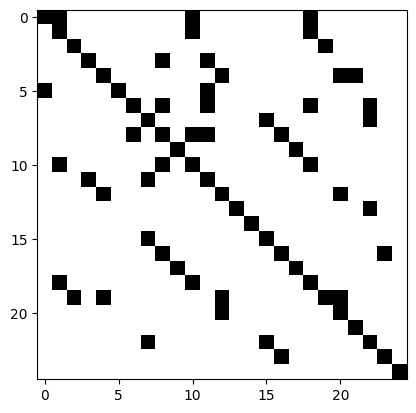

In [3]:
error_log = []

for i in range(len(paths[0])):
    try:
        run_unitmatch(paths[0][i], paths[1][i], ephys_path)
    except Exception as e:
        # Log the paths that caused the error
        error_log.append((paths[0][i], paths[1][i], str(e)))
        # Optionally, print the error for immediate feedback
        print(f"Error occurred for files: {paths[0][i]} and {paths[1][i]}. Error: {str(e)}")
        print(fr"str(e)")
        pass  # Skip to the next iteration

In [4]:
error_log

[([['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-15_14-51-19_A'],
   ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-15_15-18-02_B'],
   ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-15_15-44-58_C']],
  [['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-15_14-51-19_A_phy_k_4match'],
   ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-15_15-18-02_B_phy_k_4match'],
   ['S:/Sachuriga/Ephys_Recording/CR_CA1\\63383\\63383_2024-07-15_15-44-58_C_phy_k_4match']],
  'too many indices for array: array is 1-dimensional, but 2 were indexed'),
 ([['S:/Sachuriga/Ephys_Recording/CR_CA1\\65091\\65091_2023-08-01_13-40-26_A'],
   ['S:/Sachuriga/Ephys_Recording/CR_CA1\\65091\\65091_2023-08-01_15-16-29_C']],
  [['S:/Sachuriga/Ephys_Recording/CR_CA1\\65091\\65091_2023-08-01_13-40-26_A_phy_k_4match'],
   ['S:/Sachuriga/Ephys_Recording/CR_CA1\\65091\\65091_2023-08-01_15-16-29_C_phy_k_4match']],
  "least_squares() got an unexpected keyword argument 

In [ ]:
#sachuriga example

animal = '65588'
day = '2024-03-13'
ephys_path = 'S:\Sachuriga\Ephys_Recording\CR_CA1'
raw_path, phy_folder=load_filen(animal,day,ephys_path)
Recordings=[]

## Load Data & get good units

Spike Interface can load in many different types of Ephys data look [here](https://spikeinterface.readthedocs.io/en/latest/modules/extractors.html) for documentation on fucntion to read in different data formats. 

In [4]:
# ephys_path = 'S:\Sachuriga\Ephys_Recording\CR_CA1'
# raw_path=paths[0][0]
# phy_folder=paths[1][0]

Recordings=[]
for rp in raw_path:
    # print(rp)
    # parts = rp[0].split("\\")
    # animal = parts[1]
    # day = parts[2].split("_")[1]

    stream_name  = OpenEphysBinaryRecordingExtractor(rp[0],stream_id='0').get_streams(rp[0])[0][0]
    print(fr"Merging step_Before mannual search the stream_name. Auto search result is {stream_name}")
    record_node = stream_name.split("#")[0]
    aquisition_sys = stream_name.split("#")[1]
    recording= se.read_openephys(Path(rp[0]), stream_name=stream_name, load_sync_timestamps=True)

        
    manufacturer = 'cambridgeneurotech'
    probe_name = 'ASSY-236-F'
    probe = pi.get_probe(manufacturer, probe_name)
    print(probe)
    # probe.wiring_to_device('cambridgeneurotech_mini-amp-64')
    # map channels to device indices
    mapping_to_device = [
        # connector J2 TOP
        41, 39, 38, 37, 35, 34, 33, 32, 29, 30, 28, 26, 25, 24, 22, 20,
        46, 45, 44, 43, 42, 40, 36, 31, 27, 23, 21, 18, 19, 17, 16, 14,
        # connector J1 BOTTOM
        55, 53, 54, 52, 51, 50, 49, 48, 47, 15, 13, 12, 11, 9, 10, 8,
        63, 62, 61, 60, 59, 58, 57, 56, 7, 6, 5, 4, 3, 2, 1, 0
    ]
    probe.set_device_channel_indices(mapping_to_device)
    probe.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]
    probegroup = pi.ProbeGroup()
    probegroup.add_probe(probe)
    pi.write_prb(f"{probe_name}.prb", probegroup, group_mode="by_shank")
    recording_prb = recording.set_probe(probe, group_mode="by_shank")
    Recordings.append(recording_prb)
    
Sortings = [se.read_phy(Path(file[0])) for file in phy_folder]

#Will only make average wavefroms for good units
ExtractGoodUnitsOnly = True

Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#Acquisition_Board-100.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#Acquisition_Board-100.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#Acquisition_Board-100.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks


In [5]:
#Getting good units only
Sortings[0].get_property_keys() #lists keys for attached propties if 'quality' is not suitbale
#Good units which will be used in Unit Match
GoodUnits = []
UnitsUsed = []
ids = np.empty(len(Sortings), dtype=object) 
for i, sorting in enumerate(Sortings):
    UnitIdsTmp = sorting.get_property('original_cluster_id')
    IsGoodTmp = sorting.get_property('quality').astype(dtype='<U50')
    GoodUnits.append(np.stack((UnitIdsTmp,IsGoodTmp), axis = 1))

    UnitsUsed.append(UnitIdsTmp)
    if ExtractGoodUnitsOnly is True:
       # keep = np.argwhere(IsGoodTmp == 'good').squeeze()
        keep = np.argwhere((IsGoodTmp == 'good')).squeeze()
        idss = sorting.get_unit_ids()
        id = idss[keep]
        Sortings[i] = sorting.select_units(id)
        
        ids[i]=id.tolist()
        #ids[i] = Sortings[0].get_property('original_cluster_id')
    else:
               # keep = np.argwhere(IsGoodTmp == 'good').squeeze()
        keep = np.argwhere((IsGoodTmp == 'good') | (IsGoodTmp == 'mua')).squeeze()
        idss = sorting.get_unit_ids()
        id = idss[keep]
        Sortings[i] = sorting.select_units(id)
        
        ids[i]=id.tolist()
        #ids[i] = Sortings[0].get_property('original_cluster_id')

## Process average waveforms / templates

Beaware the spike interface method is different to the native unitmatch method in ExtractRawDemo.ipynb or in the MatLab version

In [ ]:
# # Preprocces the raw data
for recording in Recordings:
    #recording = spre.phase_shift(recording, inter_sample_shift=None) #correct for time delay between recording channels
    # bad_channel_ids, channel_labels = spre.detect_bad_channels(recording, method="coherence+psd")
    # # remove bad channels
    # recording = recording.remove_channels(bad_channel_ids)
    recording  = spre.bandpass_filter(recording, freq_min=600, freq_max=8000) #highpass
    recording = spre.common_reference(recording=recording, operator="median", reference="global")
    recording = whiten(recording, int_scale=200, mode='local', radius_um=100.0)
    # for motion correction, this can be very slow
    #Uncommented code below to do in session motion correction
    #recording = spre.correct_motion(recording, preset="nonrigid_fast_and_accurate")

for sorting in Sortings:
    #recording = spre.phase_shift(recording, inter_sample_shift=None) #correct for time delay between recording channels
    sorting.set_property(key='group', values = sorting.get_property("channel_group")) #highpass

In [7]:
#Split each recording/sorting into 2 halves                    
for i, sorting in enumerate(Sortings):
    SplitIdx = Recordings[i].get_num_samples() // 2

    SplitSorting = []
    SplitSorting.append(sorting.frame_slice(start_frame=0, end_frame=SplitIdx))
    SplitSorting.append(sorting.frame_slice(start_frame=SplitIdx, end_frame=Recordings[i].get_num_samples()))
    Sortings[i] = SplitSorting 

for i, recording in enumerate(Recordings):
    SplitIdx = recording.get_num_samples() // 2

    SplitRecording = []
    SplitRecording.append(recording.frame_slice(start_frame=0, end_frame=SplitIdx))
    SplitRecording.append(recording.frame_slice(start_frame=SplitIdx, end_frame=recording.get_num_samples()))

    Recordings[i] = SplitRecording

In [8]:
#create sorting analyzer for each pair
Analysers = []
for i in range(len(Recordings)):
    SplitAnalysers = []
    SplitAnalysers.append(si.create_sorting_analyzer(Sortings[i][0], Recordings[i][0], sparse=False))
    SplitAnalysers.append(si.create_sorting_analyzer(Sortings[i][1], Recordings[i][1], sparse=False))
    Analysers.append(SplitAnalysers)

In [9]:
#create the fast tempalte extension for each sorting analyser
AllWaveforms = []
for i in range(len(Analysers)):
    for half in range(2):
        Analysers[i][half].compute(
            "random_spikes","waveforms",
            method="uniform",
            max_spikes_per_unit=1000)
        Analysers[i][half].compute("noise_levels")
        Analysers[i][half].compute("templates")
        #Analysers[i][half].compute('fast_templates', n_jobs = 0.8,  return_scaled=True)
        #Analysers[i][half].compute('fast_templates', n_jobs = 0.8)
    TemplatesFirst = Analysers[i][0].get_extension('templates')
    TemplatesSecond = Analysers[i][1].get_extension('templates')
    t1 = TemplatesFirst.get_data()
    t2 = TemplatesSecond.get_data()
    AllWaveforms.append(np.stack((t1,t2), axis = -1))

#Make a channel_postions array
AllPositions = []
for i in range(len(Analysers)):
    #postions for first half and second half are the same
    AllPositions.append(Analysers[i][0].get_channel_locations())

noise_level (no parallelization): 100%|██████████| 20/20 [00:01<00:00, 10.60it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 643/643 [00:44<00:00, 14.49it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:01<00:00, 10.62it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 643/643 [00:47<00:00, 13.67it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:01<00:00, 10.83it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 738/738 [00:52<00:00, 13.97it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 738/738 [00:55<00:00, 13.25it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:01<00:00, 11.82it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 609/609 [00:45<00:00, 13.35it/s]
noise_level (no parallelization): 100%|██████████|

## Save extracted data in a unit match friendly folder

In [10]:
import os
import shutil
#UMInputDir = os.path.join(os.getcwd(), 'UMInputData')
UMInputDir = rf'{ephys_path}\{animal}\{animal}_{day}_UMInputData'

if os.path.exists(UMInputDir):
    shutil.rmtree(UMInputDir)
os.mkdir(UMInputDir)
AllSessionPaths = []
for i in range(len(Recordings)):
    SessionXpath = os.path.join(UMInputDir, f'Session{i+1}') #lets start at 1
    os.mkdir(SessionXpath)

    #save the GoodUnits as a .rsv first column is unit ID,second is 'good' or 'mua'
    GoodUnitsPath = os.path.join(SessionXpath, 'cluster_group.tsv')
    ChannelPositionsPath = os.path.join(SessionXpath, 'channel_positions.npy')
    SaveGoodUnits = np.vstack((np.array(('cluster_id', 'group')), GoodUnits[i])) #Title of colum one is '0000' Not 'cluster_id')
    #SaveGoodUnits[0,0] = 0 # need to be int to use np.savetxt 
    np.savetxt(GoodUnitsPath, SaveGoodUnits, fmt =['%s','%s'], delimiter='\t')
    
    if ExtractGoodUnitsOnly:        
        ids = GoodUnits[i][:,0].tolist()  # Assuming this converts ids to a list
        good = GoodUnits[i][:,1].tolist()  # Assuming this converts good to a list
        temp = [g == 'good' for g in good]  # Creates a boolean list where 'good' is found
        filtered_ids = [[id] for id, t in zip(ids, temp) if t]
        filtered_ids 
        erd.save_avg_waveforms(AllWaveforms[i], SessionXpath, filtered_ids)
    else:
        erd.save_avg_waveforms(AllWaveforms[i], SessionXpath, np.int64(GoodUnits[i][:,0]))
    np.save(ChannelPositionsPath, AllPositions[i])
    AllSessionPaths.append(SessionXpath)

Unit0
Unit1
Unit2
Unit3
Unit4
Unit5
Unit7
Unit8
Unit9
Unit10
Unit12
Unit13
Unit14
Unit15
Unit16
Unit19
Unit20
Unit24
Unit25
Unit26
Unit28
Unit31
Unit38
Unit45
Saved 25 units to RawWaveforms directory, saving all units
Unit1
Unit2
Unit7
Unit8
Unit9
Unit10
Unit11
Unit12
Unit14
Unit15
Unit18
Unit21
Unit22
Unit25
Unit26
Unit29
Unit34
Unit35
Unit36
Unit43
Unit44
Unit48
Saved 23 units to RawWaveforms directory, saving all units
Unit0
Unit1
Unit2
Unit4
Unit8
Unit10
Unit12
Unit13
Unit14
Unit15
Unit16
Unit17
Unit18
Unit19
Unit20
Unit21
Unit22
Unit23
Unit26
Unit27
Unit28
Unit29
Unit30
Unit33
Unit36
Unit38
Unit39
Unit40
Unit45
Unit47
Unit48
Unit49
Saved 33 units to RawWaveforms directory, saving all units


## Run UnitMatch

In [11]:
%reload_ext autoreload
%autoreload 
import UnitMatchPy.bayes_functions as bf
import UnitMatchPy.utils as util
import UnitMatchPy.overlord as Overlord
import numpy as np
import matplotlib.pyplot as plt
import UnitMatchPy.GUI as gui
import UnitMatchPy.save_utils as su
import UnitMatchPy.default_params as default_params
import UnitMatchPy.assign_unique_id as aid
import UnitMatchPy

In [12]:
#get default parameters, can add your own before or after!
# default of Spikeinterface as by default spike interface extracts waveforms in a different manner.
param = {'SpikeWidth': 90, 'waveidx': np.arange(15,50), 'PeakLoc': 35}
param = default_params.get_default_param(param)
param['no_shanks']=6
param['shank_dist']=175
wave_paths, unit_label_paths, channel_pos = util.paths_from_KS(AllSessionPaths)

Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv


In [80]:
1000/6

166.66666666666666

In [13]:
def zero_center_waveform(waveform):
    """
    Centers waveform about zero, by subtracting the mean of the first 15 time points.
    This function is useful for Spike Interface where the waveforms are not centered about 0.

    Arguments:
        waveform - ndarray (nUnits, Time Points, Channels, CV)

    Returns:
        Zero centered waveform
    """
    waveform = waveform -  np.broadcast_to(waveform[:,:15,:,:].mean(axis=1)[:, np.newaxis,:,:], waveform.shape)
    return waveform

In [14]:
#read in data and select the good units and exact metadata
#waveform, SessionID, SessionSwitch, WithinSession, GoodUnits, param = util.load_good_waveforms(WavePaths, UnitLabelPaths, param) # 1-step version of above
#read in data and select the good units and exact metadata

waveform, session_id, session_switch, within_session, good_units, param = util.load_good_waveforms(wave_paths, unit_label_paths,  param, good_units_only =True) 

#Recenter the waveform at 0, as is not part of spike interface tempaltes 
waveform = zero_center_waveform(waveform)

# create clusInfo, contains all unit id/session related info
clus_info = {'good_units' : GoodUnits, 'session_switch' : session_switch, 'session_id' : session_id, 
            'original_ids' : np.concatenate(GoodUnits) }
extracted_wave_properties = Overlord.extract_parameters(waveform, channel_pos, clus_info, param)

In [15]:
#Extract metric scores
total_score, candidate_pairs, scores_to_include, predictors = Overlord.extract_metric_scores(extracted_wave_properties, session_switch, within_session, param, niter  = 2)

#Probability analysis
priorMatch = 1 - (param['n_expected_matches'] / param['n_units']**2 ) # fredom of choose in prior prob?
Priors = np.array((priorMatch, 1-priorMatch))

labels = candidate_pairs.astype(int)
Cond = np.unique(labels)
ScoreVector = param['score_vector']
parameter_kernels = np.full((len(ScoreVector), len(scores_to_include), len(Cond)), np.nan)
parameter_kernels = bf.get_parameter_kernels(scores_to_include, labels, Cond, param, add_one = 1)
probability = bf.apply_naive_bayes(parameter_kernels, Priors, predictors, param, Cond)
output_prob_matrix = probability[:,1].reshape(param['n_units'],param['n_units'])

Session pair 1/2 has [2 4 3 3] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [2 5 3 3 3] matches per shank, which is below threshold to do per shank drift correction
Calculating the probability distributions of the metric scores
Calculating the match probabilities


c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:326: RuntimeWarning: divide by zero encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


The percentage of units matched to themselves is: 74.35897435897436%
The percentage of false -ve's then is: 25.641025641025635% 

The rate of miss-match(es) per expected match 0.07692307692307693
The percentage of false +ve's is 0.0% for session 1
The percentage of false +ve's is 0.0% for session 2
The percentage of false +ve's is 0.6048387096774194% for session 3

This assumes that the spike sorter has made no mistakes


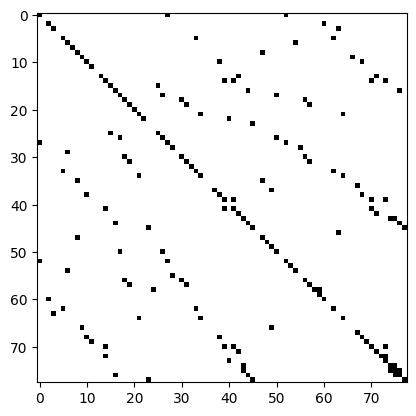

In [16]:
util.evaluate_output(output_prob_matrix, param, within_session, session_switch, match_threshold = 0.75)
match_threshold = param['match_threshold']
OutputThreshold = np.zeros_like(output_prob_matrix)
OutputThreshold[output_prob_matrix > match_threshold] = 1
plt.imshow(OutputThreshold, cmap = 'Greys')

In [17]:
amplitude = extracted_wave_properties['amplitude']
spatial_decay = extracted_wave_properties['spatial_decay']
avg_centroid = extracted_wave_properties['avg_centroid']
avg_waveform = extracted_wave_properties['avg_waveform']
avg_waveform_per_tp = extracted_wave_properties['avg_waveform_per_tp']
wave_idx = extracted_wave_properties['good_wave_idxs']
max_site = extracted_wave_properties['max_site']
max_site_mean = extracted_wave_properties['max_site_mean']
gui.process_info_for_GUI(output_prob_matrix, match_threshold, scores_to_include, total_score, amplitude, spatial_decay,
                         avg_centroid, avg_waveform, avg_waveform_per_tp, wave_idx, max_site, max_site_mean, 
                         waveform, within_session, channel_pos, clus_info, param)

In [20]:
matches = np.argwhere(match_threshold == 0.99)
UIDs = aid.assign_unique_id(output_prob_matrix, param, clus_info)

SaveDir = rf'{ephys_path}\{animal}\{animal}_{day}_unitmatchResults'
su.save_to_output(SaveDir, scores_to_include, matches, output_prob_matrix, avg_centroid, avg_waveform, avg_waveform_per_tp, max_site,
                   total_score, OutputThreshold,  clus_info, param, UIDs=None,matches_curated = True, save_match_table = True,)

Number of Liberal Matches: 43
Number of Intermediate Matches: 40
Number of Conservative Matches: 39


In [ ]:
import pandas as pd
ephys_path = 'S:\Sachuriga\Ephys_Recording\CR_CA1'

df = pd.read_csv(rf'{ephys_path}\{animal}\{animal}_{day}_unitmatchResults\MatchTable.csv')

In [ ]:
df1 = df[df['Matches']==1]
df2=df1[df1['RecSes 2']==1]
df2

,ID1,ID2,RecSes 1,RecSes 2,Matches,UM Probabilities,TotalScore,amp_score,spatial_decay_score,centroid_overlord_score,...,waveform_score,trajectory_score,UID1,UID2,UID Liberal 1,UID Liberal 2,UID int 1,UM UID int 2,UID Conservative 1,UID Conservative 2
8,8,0,1,1,1,0.559306,0.647287,0.608143,0.477241,0.786212,...,0.524703,0.705955,8,0,8,0,8,0,8,0
9,9,0,1,1,1,0.593231,0.572245,0.759985,0.668933,0.780498,...,0.716107,0.808139,9,0,9,0,9,0,9,0
13,13,0,1,1,1,0.559860,0.572686,0.524698,0.612198,0.838065,...,0.942391,0.818306,13,0,9,0,13,0,13,0
22,0,0,2,1,1,0.709685,0.658443,0.769625,0.625613,0.668425,...,0.472092,0.637037,22,0,8,0,8,0,8,0
41,19,0,2,1,1,0.913726,0.699042,0.353980,0.632082,0.662658,...,0.877444,0.795453,41,0,0,0,41,0,41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088,17,17,1,1,1,0.933529,0.746816,0.513099,0.734521,0.870367,...,0.741050,0.692176,17,17,17,17,17,17,17,17
1173,17,18,2,1,1,0.715759,0.680894,0.637730,0.582328,0.852550,...,0.530898,0.629360,39,18,39,18,39,18,39,18
1216,19,19,1,1,1,0.987612,0.848461,0.833453,0.640790,0.904606,...,0.831356,0.803380,19,19,19,19,19,19,19,19
1280,20,20,1,1,1,0.942852,0.777733,0.512300,0.538741,0.965920,...,0.882581,0.767136,20,20,20,20,20,20,20,20


: 

In [ ]:
xx, yy = np.meshgrid(original_ids, original_ids)
unit_a_list = xx.reshape(n_units*n_units)
unit_b_list = yy.reshape(n_units*n_units)


In [ ]:
np.meshgrid(original_ids, original_ids)

[array([['0', 'mua', '1', ..., 'mua', '19', 'mua'],
        ['0', 'mua', '1', ..., 'mua', '19', 'mua'],
        ['0', 'mua', '1', ..., 'mua', '19', 'mua'],
        ...,
        ['0', 'mua', '1', ..., 'mua', '19', 'mua'],
        ['0', 'mua', '1', ..., 'mua', '19', 'mua'],
        ['0', 'mua', '1', ..., 'mua', '19', 'mua']], dtype='<U50'),
 array([['0', '0', '0', ..., '0', '0', '0'],
        ['mua', 'mua', 'mua', ..., 'mua', 'mua', 'mua'],
        ['1', '1', '1', ..., '1', '1', '1'],
        ...,
        ['mua', 'mua', 'mua', ..., 'mua', 'mua', 'mua'],
        ['19', '19', '19', ..., '19', '19', '19'],
        ['mua', 'mua', 'mua', ..., 'mua', 'mua', 'mua']], dtype='<U50')]

In [ ]:
import pandas as pd
ephys_path = 'S:\Sachuriga\Ephys_Recording\CR_CA1'

df = pd.read_csv(rf'{ephys_path}\{animal}\{animal}_{day}_unitmatchResults\MatchTable.csv')

In [ ]:
df1 = df[df['Matches']==1]
df2=df1[df1['RecSes 2']==1]
df

,ID1,ID2,RecSes 1,RecSes 2,Matches,UM Probabilities,TotalScore,AmpScore,SpatialDecayScore,CentroidOverlord,CentroidDist,WaveformScore,TrajectoryScore
0,6,6,1,1,1,0.999981,0.896175,0.601483,0.762703,0.976545,0.980322,0.979726,0.874412
1,7,6,1,1,0,0.002614,0.681720,0.753830,0.520181,0.843550,0.851751,0.693527,0.526268
2,9,6,1,1,0,0.000090,0.397127,0.760701,0.570237,0.836600,0.000000,0.322726,0.390256
3,10,6,1,1,0,0.000107,0.333470,0.562141,0.533055,0.745555,0.000000,0.458230,0.288840
4,11,6,1,1,0,0.000012,0.315856,0.604460,0.354040,0.838837,0.000000,0.341712,0.367779
...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,4,9,3,3,0,0.000004,0.199958,0.156988,0.139472,0.532109,0.000000,0.809808,0.335541
621,5,9,3,3,0,0.000002,0.159651,0.199129,0.019742,0.682884,0.000000,0.382431,0.504397
622,6,9,3,3,0,0.000002,0.106621,0.023560,0.034076,0.725807,0.000000,0.302507,0.458798
623,7,9,3,3,0,0.000017,0.204853,0.364767,0.023311,0.183797,0.657460,0.286014,0.481078


In [ ]:
rf'{ephys_path}\{animal}\{animal}_{day}_unitmatchResults\MatchTable.csv'

'S:\\Sachuriga\\Ephys_Recording\\CR_CA1\\65588\\65588_2024-03-12_unitmatchResults\\MatchTable.csv'